In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

In [2]:
# Unquote one comment in: 
# Bullet 7 (if Production.size == 0:)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
Country = 'China'
subregion = 'BRA.25.548_2'

In [5]:
####################
# 1. Intial run values 
####################

# For tracking changes in data generated through script and GEE attribution dataset
Dataset_version = 1
GEE_data_version = 0
Python_script_version = 0
Year = '(2001-2022)'

end_year = 2022                                              # Year upto which the simulation runs
end_year_FAO_Landuse = 2021;                                 # Last avaiable year of FAO landuse dataset (will help with gap-filling)
#end_year_FAO_Production = 2021                              # Last avaiable year of FAO Production dataset (will help with gap-filling) - to be ajusted in section 7
#end_year_IBGE_Production = 2022                             # For IBGE - to be ajusted in section 7
lag = 3                                                      # Considered as the lag between detected forest loss and establised agriculture stats in FAO
amortized_period = 5                                         # Time over which the final deforestation and carbon footprint are averaged

# Details about classification codes in Supplementary Information
redundant_agriculture_classes = 5182                         # Classes name is 'Unknown Tree Crop'
redundant_plantation_class = 5181                            # Class name is 'Unknown Forest Plantation'

# Classes that need to attributed to other classes using statistical attribution
Hansen_Unattributed = [1]                                    # Not attributed to any land use
MapBiomas_Farming = [3050]                                   # Can be attributed to agriculture/cropland, pasture and forest plantation
MapBiomas_Mosiac = [3100]                                    # Can be attributed to agriculture/cropland and pasture
Dominant_Agriculture = [3000]                                # Can be attributed to agriculture/cropland and pasture; treated differently than the class below

Dominant_forestry = [500]                                    # For attributing values to only plantation
Broad_LU_Undefined = [9000]                                  # All unattributed values after during the land-balance go here

MapBiomas_FarmingMosiac_cropland = [3150]
MapBiomas_FarmingMosiac_pasture = [4000]
MapBiomas_FarmingMosiac_plantation = [5000]
Dominant_cropland = [3151]
Dominant_pasture = [4001]
Dominant_plantation = [6501]
Hansen_cropland = [3152]
Hansen_pasture = [4002]
Hansen_plantation = [6502]
GlobalPlantation_treecrop = [3801]

necessary_classes = [500,3150,3151,3152,3801,4000,4001,4002,5000,6501,6502,9000]   # Classes to which all landuse is attributed to Forestry, Pasture, Plantations and Discarded/Undefined

Broad_cropland = [3150, 3151, 3152, 3200, 3201, 3800, 3801]
Broad_cropland_limited = [3152, 3151, 3201, 3150, 3200, 3800, 3801] 
Broad_pasture = [4000, 4001, 4002]
Broad_plantation = [5000, 6501, 6502]

# Potential ranges for cropland, pasture and forest plantations in our reclassification (Plantation species (mostly from Du et al. 2021) that overlap with FAO commodities will ultimately be counted in cropland)
Broad_LU_Agriculture_start, Broad_LU_Agriculture_end = 3150,3999     
Broad_LU_Pasture_start, Broad_LU_Pasture_end = 4000,4999
Broad_LU_Plantation_start, Broad_LU_Plantation_end = 5000,6999

# Countries that will not follow (i.e., grouping) national scale attribution
Country_with_subnational_attribution = ['Brazil'] 


In [6]:
####################
# 2. Update and load all necessary datasets 
####################

home_folder = '/home/chandra/backup/Chalmers/'
Simulation_version = 'DeDuCE v'+str(Dataset_version)+'.'+str(GEE_data_version)+'.'+str(Python_script_version)+' ' + Year

GEE_datasets_version = home_folder+Simulation_version+'/DeDuCE_dataset_GEE'       # Directory of the latest GEE run csv files
FAO_Landuse_version = home_folder+'FAOSTATS/Inputs_LandUse_E_All_Data_(Normalized).csv'                                    # Download the latest FAO Landuse dataset (https://www.fao.org/faostat/en/#home) - directly from bulk dataset
FAO_Production_version = home_folder+'FAOSTATS/Production_Crops_Livestock_E_All_Data_(Normalized).csv'                     # Download the latest FAO Production dataset (https://www.fao.org/faostat/en/#home)
Global_FRA_version = home_folder+'FAOSTATS/fra-forestCharacteristics.csv'                                                  # Download the latest FAO Production dataset (https://www.fao.org/faostat/en/#home)

Crop_and_grass_loss = home_folder+'Other_datasets/Li_et_al_2017_Gross_cropland_grassland_changes_2001-2020 - gapfilled_2021-2022.xlsx'   # Updated from Li et al 2018 (https://essd.copernicus.org/articles/10/219/2018/) - values for 2021 are same as 2020; 
                                                                                                                                         # Check the latest data at https://maps.elie.ucl.ac.be/CCI/viewer/download.php
# Update from the following link (last updated till year 2021): https://sidra.ibge.gov.br/pesquisa/pam/tabelas
IBGE_dataset_version = home_folder+'IBGE dataset'             
# Contains code for commodities, primarily from MapBiomas and Du et al. plantation
Commodity_lookup_codes = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-Commodity Code')                  
# Contains FAO names for GADM countries
Country_lookup_codes = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-Country (GADM vs FAO)') 
# Contains Ecoregion group for GADM countries
Country_lookup_codes_ecoregion = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-Country (GADM)')          
# Contains group for all FAO vcommodities
Commodity_group = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-FAO commodity')  
# Contains Soil Organic carbon loss data 
SOC_loss = (pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-SOC Loss').iloc[:8, :5])    
# Sequestration potential of replacing land use
Commodity_replacement_potential = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-Carbon seq. potential')  
# Pealand emission factor
Peatland_emission_factors = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-Peatland emission factor')
# Contains matching FAO names for IBGE commodities 
IBGE_crops = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-IBGE crops')                                  
# Contains subnational GADM code for Brazil. First row contains miscellaneous table info and are therefore skipped.
IBGE_municipality = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Lookup-Brazil (GADM vs IBGE)', skiprows=[0])  
# Contains Score and Overall accuracy for GADM countries
Quality_assessment_lookup_codes = pd.read_excel(home_folder+Simulation_version+'/Supplementary_data-DeDuCE v1.xlsx', 'Scoring')

In [7]:
####################
# 3.1 Extracting and pre-processing GEE and FAO files
####################

## Function to extract GEE files 
def find_forest_loss_files(Countries, directory_path):
    # Searches for forest loss files for the specified countries in the directory and merges the data across rows
    
    classification_files = []
    AGB_files = []
    BGB_files = []
    Topsoil_SOC_files = []
    Subsoil_SOC_files = []
    Peatland_files = []
    
    for Country in Countries:
        # Pattern of files that need to be extracted
        # Searches for 'Forest_loss_to_CLASSIFICATION_X_*.csv', 'Forest_loss_to_AGB_EMISSIONS_[COUNTRY]_*.csv' and 'Forest_loss_to_BGB_EMISSIONS_[COUNTRY]_*.csv'
        # files in the specified directory and returns their file paths when [Country] is defined in the start.
        classification_file_pattern = 'Forest_loss_to_CLASSIFICATION_' + str(Country) + '_'
        AGB_file_pattern = 'Forest_loss_to_AGB_EMISSION_' + str(Country) + '_'
        BGB_file_pattern = 'Forest_loss_to_BGB_EMISSION_' + str(Country) + '_'
        Topsoil_SOC_file_pattern = 'Forest_loss_to_SOC_0_30_' + str(Country) + '_'
        Subsoil_SOC_file_pattern = 'Forest_loss_to_SOC_30_100_' + str(Country) + '_'
        Peatland_file_pattern = 'Forest_loss_to_PEATLAND_' + str(Country) + '_'
        
        # Get a list of all the matching file paths
        FLC_file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if classification_file_pattern in f]
        AGB_file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if AGB_file_pattern in f]
        BGB_file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if BGB_file_pattern in f]
        Topsoil_SOC_file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if Topsoil_SOC_file_pattern in f]
        Subsoil_SOC_file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if Subsoil_SOC_file_pattern in f]
        Peatland_file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if Peatland_file_pattern in f]

        # The code will show an error when multiple files are read for the same category
        if len(FLC_file_paths) > 1 or len(AGB_file_paths) > 1 or len(BGB_file_paths) > 1 or \
                len(Topsoil_SOC_file_paths) > 1 or len(Subsoil_SOC_file_paths) > 1 or \
                len(Peatland_file_paths) > 1:
            print(Country, subregion,'\033[91m' + 'Multiple forest loss attribution files for the same country' + '\033[0m')
        
        try:
            classification_file = pd.read_csv(FLC_file_paths[0])
            AGB_file = pd.read_csv(AGB_file_paths[0])
            BGB_file = pd.read_csv(BGB_file_paths[0])
            Topsoil_SOC_file = pd.read_csv(Topsoil_SOC_file_paths[0])
            Subsoil_SOC_file = pd.read_csv(Subsoil_SOC_file_paths[0])
            Peatland_file = pd.read_csv(Peatland_file_paths[0])
            
            classification_files.append(classification_file)
            AGB_files.append(AGB_file)
            BGB_files.append(BGB_file)
            Topsoil_SOC_files.append(Topsoil_SOC_file)
            Subsoil_SOC_files.append(Subsoil_SOC_file)
            Peatland_files.append(Peatland_file)
        except pd.errors.EmptyDataError:
            continue
    
    if not classification_files:
        return None, None, None, None, None, None
    # Merge the data across rows
    merged_classification = pd.concat(classification_files, ignore_index=True)
    merged_AGB = pd.concat(AGB_files, ignore_index=True)
    merged_BGB = pd.concat(BGB_files, ignore_index=True)
    merged_Topsoil_SOC = pd.concat(Topsoil_SOC_files, ignore_index=True)
    merged_Subsoil_SOC = pd.concat(Subsoil_SOC_files, ignore_index=True)
    merged_Peatland = pd.concat(Peatland_files, ignore_index=True)
    #return classification and AGB/BGB files
    return merged_classification, merged_AGB, merged_BGB, merged_Topsoil_SOC, merged_Subsoil_SOC, merged_Peatland


## Function to extract FAO Landuse files 
def preprocessing_dataframe_landuse_FAO(Landuse, Country):
    if Country == 'French Guiana':
        Country = 'French Guyana'
        
    Landuse = Landuse[['Area', 'Item', 'Year', 'Value', 'Flag']]
    Landuse['Value'] = Landuse['Value']*1000       # FAO 'Area harvested' values are in 1000 ha 
    Landuse = Landuse.sort_values(by = 'Year')
    Landuse = Landuse[(Landuse['Year'] >= 2001)]   # Screen values before year 2000
    
    if Country == 'Serbia':
        Landuse = Landuse[Landuse['Area'].isin(['Serbia', 'Montenegro', 'Serbia and Montenegro'])]
        Landuse['Area'] = Country
    elif Country == 'Sudan':
        Landuse = Landuse[Landuse['Area'].isin(['Sudan', 'South Sudan', 'Sudan (former)'])]
        Landuse['Area'] = Country
    elif Country == 'China, mainland':
        Landuse = Landuse[Landuse['Area'].isin(['China, mainland', 'China, Hong Kong SAR', 'China, Macao SAR'])]
        Landuse['Area'] = Country
    else:        
        Landuse = Landuse[Landuse['Area'] == Country]
    Landuse = Landuse[Landuse['Item'].isin(['Cropland', 'Permanent meadows and pastures', 'Planted Forest'])]      # Since we are only interested in cropland expansion, pasture expansion and plantation expansion
    Landuse["Item"] = Landuse["Item"].replace("Planted Forest", "Plantation")                                             # Replace column name 
    Landuse["Item"] = Landuse["Item"].replace("Permanent meadows and pastures", "Pasture")
    Landuse = Landuse.groupby(['Area', 'Item', 'Year']).agg({'Flag': np.min, 'Value': 'sum'}).reset_index()               # Clean the data when multiple countries area being read
    Landuse = Landuse.pivot_table(index=['Area', 'Year'], columns=['Item'], values=['Value', 'Flag'], aggfunc='first')

    # flatten the column names
    Landuse.columns = ['_'.join(col).rstrip('_') for col in Landuse.columns.values]
    # reset the index
    Landuse = Landuse.reset_index()

    Landuse[['Area', 'Year'] + [col for col in Landuse.columns if col.startswith('Value_')]] = Landuse[['Area', 'Year'] + [col for col in Landuse.columns if col.startswith('Value_')]].fillna(0)
    Landuse[[col for col in Landuse.columns if col.startswith('Flag_')]] = Landuse[[col for col in Landuse.columns if col.startswith('Flag_')]].fillna('Z')
    return Landuse


## Function to extract FAO production files 
def preprocessing_dataframe_crop_livestock_FAO(Production, Country):
    if Country == 'Netherlands (Kingdom of the)':
        Country = 'Netherlands'
    
    Production = Production[Production['Element'] == 'Area harvested']
    Production = Production[['Area', 'Item', 'Year', 'Value', 'Flag', 'Item Code (CPC)']]
    Production = Production.sort_values(by = 'Year')
    Production = Production[(Production['Year'] >= 2001) & (Production['Year'] <= end_year)]                              # Change this to the last year. Forcefully restricting to year 2021
    if Country == 'Serbia':
        Production = Production[Production['Area'].isin(['Serbia', 'Montenegro', 'Serbia and Montenegro'])]
        Production['Area'] = Country
    elif Country == 'Sudan':
        Production = Production[Production['Area'].isin(['Sudan', 'South Sudan', 'Sudan (former)'])]
        Production['Area'] = Country
    elif Country == 'China, mainland':
        Production = Production[Production['Area'].isin(['China, mainland', 'China, Hong Kong SAR', 'China, Macao SAR'])]
        Production['Area'] = Country
    else:
        Production = Production[Production['Area'] == Country]
    
    unique_code = Production['Item Code (CPC)'].unique()
    mask = np.array([not s.startswith('\'F') for s in unique_code])
    unique_code = unique_code[mask]
    
    Production = Production.loc[Production['Item Code (CPC)'].isin(unique_code)]
    unique = Production['Item'].unique()                                                                                   # Unique values are used for commodity attribution
    Production = Production.groupby(['Area', 'Item', 'Year']).agg({'Flag': np.min, 'Value': 'sum'}).reset_index()          # Clean the data when multiple countries area being read
    Production = Production.pivot_table(index=['Area', 'Year'], columns=['Item'], values=['Value', 'Flag'], aggfunc='first')
    
    Production.columns = ['_'.join(col).rstrip('_') for col in Production.columns.values]
    # reset the index
    Production = Production.reset_index()
    
    Production[['Area', 'Year'] + [col for col in Production.columns if col.startswith('Value_')]] = Production[['Area', 'Year'] + [col for col in Production.columns if col.startswith('Value_')]].fillna(0)
    Production[[col for col in Production.columns if col.startswith('Flag_')]] = Production[[col for col in Production.columns if col.startswith('Flag_')]].fillna('Z')
    return Production, unique



    
# Function to extract forest plantation dataset from FRA (https://fra-data.fao.org/assessments/fra/2020)
def preprocessing_dataframe_FRA(Global_Forest_Resources_Assessment, Country):
    if Country == 'China, mainland':
        Country = 'China'
    if Country == 'French Guiana':
        Country = 'French Guyana'
    if Country == 'Côte d\'Ivoire':
        Country = 'CÃ´te d\'Ivoire'
    if Country == 'Türkiye':
        Country = 'TÃ¼rkiye'
    
    Global_Forest_Resources_Assessment = Global_Forest_Resources_Assessment.rename(columns = {'Unnamed: 0': 'Area'})
    Global_Forest_Resources_Assessment = Global_Forest_Resources_Assessment.fillna(0)
    Global_Forest_Resources_Assessment['Area'] = Global_Forest_Resources_Assessment['Area'].str.replace(' \(Desk study\)', '', regex=True)
    Global_Forest_Resources_Assessment = Global_Forest_Resources_Assessment[Global_Forest_Resources_Assessment['Area'] == Country]
        
    # Values to add (Since data is only avaialble for year 2000 and 2010)
    years_to_add = np.linspace(2000, 2010, 10 + 1)[1:-1]
    values_to_add = np.linspace(Global_Forest_Resources_Assessment['2000'].values[0], Global_Forest_Resources_Assessment['2010'].values[0], 10 + 1)[1:-1]
    # Add the values as new columns to the DataFrame
    for year, value in zip(years_to_add, values_to_add):
        Global_Forest_Resources_Assessment[str(int(year))] = value
            
    # Values to add(Since data is only avaialble for year 2010 and 2015)
    years_to_add = np.linspace(2010, 2015, 5 + 1)[1:-1]
    values_to_add = np.linspace(Global_Forest_Resources_Assessment['2010'].values[0], Global_Forest_Resources_Assessment['2015'].values[0], 5 + 1)[1:-1]
    # Add the values as new columns to the DataFrame
    for year, value in zip(years_to_add, values_to_add):
        Global_Forest_Resources_Assessment[str(int(year))] = value
            
    if '2021' not in Global_Forest_Resources_Assessment.columns:
        Global_Forest_Resources_Assessment['2021'] = Global_Forest_Resources_Assessment['2020'] + ((Global_Forest_Resources_Assessment['2018']-Global_Forest_Resources_Assessment['2017']) + \
                                                                                                       (Global_Forest_Resources_Assessment['2019']-Global_Forest_Resources_Assessment['2018']) + \
                                                                                                        (Global_Forest_Resources_Assessment['2020']-Global_Forest_Resources_Assessment['2019']))/3
    Global_Forest_Resources_Assessment = Global_Forest_Resources_Assessment.sort_index(axis=1)
    Global_Forest_Resources_Assessment = Global_Forest_Resources_Assessment.loc[:, '2001':'2021']
    Global_Forest_Resources_Assessment = Global_Forest_Resources_Assessment*1000
    return Global_Forest_Resources_Assessment.values[0]



####################
# 3.2 Specify specific sub-national commodity functions
####################

# Run this funtion outside the main-function to reduce time
# Defined below for Brazil 
def preprocessing_dataframe_production_IBGE():
    # Orientation of the table downloaded from IBGE: https://sidra.ibge.gov.br/pesquisa/pam/tabelas
    # Tabela 5457 - Área plantada ou destinada à colheita, área colhida, quantidade produzida, rendimento médio e valor da produção das lavouras temporárias e permanentes 
    # in Portuguese: ['Município', 'Variável', 'Ano', 'Produto das lavouras temporárias e permanentes', 'Values of commodities ha']
    # in English: ['Municipality', 'Variable', 'Year', 'Product of temporary and permanent crops', 'Values of commodities ha']

    # File path where IBGE datasets are stored
    dataset_path = IBGE_dataset_version
    # Here we specifically read Tabela 5457 with contains 'Area planted or destined for harvest, harvested area, quantity produced, average yield and production value of temporary and permanent crops'
    file_pattern = 'tabela5457-'
    csv_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if file_pattern in f]
    data = []
    
    # Loop through all csv files (downloaded in parts as the size of individual csv is quite large)
    for file in csv_files:
        try:
            production = pd.read_csv(file, skiprows=[0])
            # Since we are intersted in Plantation area, we extract 'Área plantada ou destinada à colheita (Hectares)' -> (English translation) 'Area planted or intended for harvesting (Hectares)'
            production = production.loc[production['Variável'] == 'Área plantada ou destinada à colheita (Hectares)'] \
                                                        [['Município', 'Ano', 'Produto das lavouras temporárias e permanentes', 'Unnamed: 4']]
            production = production.rename(columns = {'Município': 'Area', 'Ano': 'Year', 'Produto das lavouras temporárias e permanentes': 'Item', 'Unnamed: 4': 'Value'})
            production['Item'] = production['Item'].map(IBGE_crops.set_index('IBGE Crops')['FAO name'])
            
            # Skip if there is no column
            if not production.empty:
                data.append(production)
        
        except pd.errors.EmptyDataError:
            #print('CSV file is empty')
            continue
    
    if not data:
        return None
    
    production_df = pd.concat(data)
    production_df = production_df.pivot_table(index=['Area', 'Year'], columns=['Item'], values=['Value'], aggfunc='first')
    production_df.columns = ['_'.join(col).rstrip('_') for col in production_df.columns.values] # Creates columns with name 'Value_'+[Commodity]
    production_df = production_df.reset_index()
    production_df[['Area', 'Year'] + [col for col in production_df.columns if col.startswith('Value_')]] = production_df[['Area', 'Year'] + [col for col in production_df.columns if col.startswith('Value_')]].fillna(0)
    production_df = production_df.replace('-', 0)     # Replacing empy columns with zero
    production_df = production_df.replace('...', 0)   # Replacing empy columns with zero
    production_df['Year'] = production_df['Year'].astype(int)
    return production_df


# Replacing with first harvest 
def preprocessing_dataframe_production_IBGE_multicropping(Crop):
    # Orientation of the table downloaded from IBGE: https://sidra.ibge.gov.br/pesquisa/pam/tabelas
    # Tabela 5457 - Área plantada ou destinada à colheita, área colhida, quantidade produzida, rendimento médio e valor da produção das lavouras temporárias e permanentes 
    # in Portuguese: ['Município', 'Variável', 'Ano', 'Produto das lavouras temporárias e permanentes', 'Values of commodities ha']
    # in English: ['Municipality', 'Variable', 'Year', 'Product of temporary and permanent crops', 'Values of commodities ha']

    # File path where IBGE datasets are stored
    dataset_path = IBGE_dataset_version
    # Here we specifically read Tabela 5457 with contains 'Area planted or destined for harvest, harvested area, quantity produced, average yield and production value of temporary and permanent crops'
    if Crop == 'Maize (corn)':
        file_pattern = 'tabela839'
        cropname = 'Milho (em grão) - 1ª safra'
    elif Crop == 'Groundnuts, excluding shelled':
        file_pattern = 'tabela1000'
        cropname = 'Amendoim (em casca) - 1ª safra'
    elif Crop == 'Potatoes':
        file_pattern = 'tabela1001'
        cropname = 'Batata-inglesa - 1ª safra'
    elif Crop == 'Beans, dry':
        file_pattern = 'tabela1002'
        cropname = 'Feijão (em grão) - 1ª safra'
    
    csv_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if file_pattern in f]
    data = []
    
    # Loop through all csv files (downloaded in parts as the size of individual csv is quite large)
    for file in csv_files:
        try:
            production = pd.read_csv(file, skiprows=[0])
            # Since we are intersted in Plantation area, we extract 'Área plantada ou destinada à colheita (Hectares)' -> (English translation) 'Area planted or intended for harvesting (Hectares)'
            production = production.loc[production['Variável'] == 'Área plantada (Hectares)'] \
                                                        [['Município', 'Ano', 'Produto das lavouras temporárias', 'Unnamed: 4']]
            production = production.rename(columns = {'Município': 'Area', 'Ano': 'Year', 'Produto das lavouras temporárias': 'Item', 'Unnamed: 4': 'Value'})
            production = production.loc[production['Item'] == cropname]
            
            # Skip if there is no column
            if not production.empty:
                data.append(production)
        
        except pd.errors.EmptyDataError:
            #print('CSV file is empty')
            continue
    if not data:
        return None
    
    production_df = pd.concat(data)
    production_df = production_df.pivot_table(index=['Area', 'Year'], columns=['Item'], values=['Value'], aggfunc='first')
    production_df.columns = ['_'.join(col).rstrip('_') for col in production_df.columns.values] # Creates columns with name 'Value_'+[Commodity]
    production_df = production_df.reset_index()
    production_df[['Area', 'Year'] + [col for col in production_df.columns if col.startswith('Value_')]] = production_df[['Area', 'Year'] + [col for col in production_df.columns if col.startswith('Value_')]].fillna(0)
    production_df = production_df.replace('-', 0)     # Replacing empy columns with zero
    production_df = production_df.replace('...', 0)   # Replacing empy columns with zero
    production_df['Year'] = production_df['Year'].astype(int)
    production_df = production_df.rename(columns = {'Value_'+cropname: 'Value_'+Crop})

    # Set 'Area' and 'Year' as the index in both DataFrames
    Production_IBGE.set_index(['Area', 'Year'], inplace=True)
    production_df.set_index(['Area', 'Year'], inplace=True)
    
    # Update values from 'Production_IBGE' with values from 'production_df'
    Production_IBGE.update(production_df, overwrite=True)
    # Reset the index to the default
    Production_IBGE.reset_index(inplace=True)
    return Production_IBGE

# Extract SOC loss values from the table based on depth and Ecoregion
def extract_SOC_numeric(SOC_loss, Depth, Country_Ecoregion, Landuse):
    Symbol = ''
    Value = SOC_loss.loc[(SOC_loss['Depth'] == Depth) & (SOC_loss['Ecoregion group'] == Country_Ecoregion), Landuse].values[0]
    
    if isinstance(Value, (int, float)):
        # Value is already numeric, no further processing needed
        pass
    elif isinstance(Value, str):
        # Value is a string, attempt to replace symbols
        symbols_to_replace = ['†', '*']  # Add more symbols if needed
        for symbol in symbols_to_replace:
            if symbol in Value:
                try:
                    Value = int(float(Value.replace(symbol, '').replace(',', '')))  # Convert to float instead of int
                    Symbol = symbol  # Store the symbol that was successfully replaced
                    break
                except ValueError:
                    # Handle the case where the string can't be converted to a float
                    print(f"Error converting to float for symbol: {symbol}")
    else:
        print("Unknown Data Type")

    return Value, Symbol


In [8]:
####################
# 4. Pre-processing: Land balance - Extracting land use attributed to certain land uses/commodities  
####################
"""
## Function starts here
"""

'\n## Function starts here\n'

In [9]:
Country_ISO = Country_lookup_codes.loc[Country_lookup_codes['GADM Countries'] ==  Country, 'GID_0'].values[0]                 # Match country with ISO code
Country_FAO = Country_lookup_codes.loc[Country_lookup_codes['GADM Countries'] ==  Country, 'FAO countries'].values[0]         # Match country with FAO country name
Country_GADM = Country_lookup_codes.loc[Country_lookup_codes['GADM Countries'] ==  Country, 'GADM Countries'].values[0]       # Save GADM country name for incorporating in final export
Country_Ecoregion = Country_lookup_codes_ecoregion.loc[Country_lookup_codes_ecoregion['COUNTRY'] ==  Country, 'ECOREGION GROUP'].values[0]
Country_Group = Country_lookup_codes_ecoregion.loc[Country_lookup_codes_ecoregion['COUNTRY'] ==  Country, 'COUNTRY GROUP'].values[0]

In [10]:
# Addressing special character in country names
if Country == 'Åland':
    Country = 'Aland'
elif Country =='Côte d\'Ivoire':
    Country = 'Cote dIvoire'
elif Country == 'Curaçao':
    Country = 'Curacao'
elif Country == 'México':
    Country = 'Mexico'
elif Country == 'Réunion':
    Country = 'Reunion'
elif Country == 'Saint-Barthélemy':
    Country = 'Saint-Barthelemy'
elif Country == 'São Tomé and Príncipe':
    Country = 'Sao Tome and Principe'


In [11]:
# Calling the Forest_loss_attributed function

if Country == 'Serbia':
    Forest_loss_attributed, AGB, BGB, SOC_top, SOC_sub, Peatland = find_forest_loss_files(['Serbia','Montenegro'], GEE_datasets_version)
    Forest_loss_attributed['COUNTRY'] = Country
    AGB['COUNTRY'] = Country
    BGB['COUNTRY'] = Country
    SOC_top['COUNTRY'] = Country
    SOC_sub['COUNTRY'] = Country
    Peatland['COUNTRY'] = Country
elif Country == 'Sudan':
    Forest_loss_attributed, AGB, BGB, SOC_top, SOC_sub, Peatland = find_forest_loss_files(['Sudan','South Sudan'], GEE_datasets_version)
    Forest_loss_attributed['COUNTRY'] = Country
    AGB['COUNTRY'] = Country
    BGB['COUNTRY'] = Country
    SOC_top['COUNTRY'] = Country
    SOC_sub['COUNTRY'] = Country
    Peatland['COUNTRY'] = Country
else:
    Forest_loss_attributed, AGB, BGB, SOC_top, SOC_sub, Peatland = find_forest_loss_files([Country], GEE_datasets_version)

In [12]:
((SOC_top[SOC_top['Class'] > 0])[[f'loss_{year}' for year in range(2001, end_year+1)]].sum()/10**6).sum()

1711.3285263665225

In [13]:
((SOC_sub[SOC_sub['Class'] > 0])[[f'loss_{year}' for year in range(2001, end_year+1)]].sum()/10**6).sum()

220.78103103626836

In [14]:
def preprocess_dataframe(df, subregion, necessary_classes, end_year):
    if Peatland.empty:
        # Create an empty row with zeros
        new_row = pd.DataFrame(0, index=[0], columns=df.columns)
        # Concatenate the empty row to the existing DataFrame
        df = pd.concat([new_row, df]).reset_index(drop=True)
    if Country in Country_with_subnational_attribution:
        df = (df.loc[df['GID_2'] == subregion].groupby(['COUNTRY', 'GID_2', 'Class']).sum().reset_index()[['COUNTRY', 'Class'] \
                        + [f'loss_{year}' for year in range(2001, end_year+1)]]).iloc[:,1:]
    else:
        df = (df.groupby(['COUNTRY', 'Class']).sum().reset_index()[['COUNTRY', 'Class'] \
                        + [f'loss_{year}' for year in range(2001, end_year+1)]]).iloc[:,1:]
    for column in necessary_classes:
        if not (df['Class'] == column).any():
            df.loc[len(df.index)] = [column] + [0] * (len(df.columns) - 1)
    df.set_index('Class', inplace=True)
    df.sort_values(by='Class', ascending=False, inplace=True)
    return df

Forest_loss_attributed = preprocess_dataframe(Forest_loss_attributed, subregion, necessary_classes, end_year)
AGB = preprocess_dataframe(AGB, subregion, necessary_classes, end_year)
BGB = preprocess_dataframe(BGB, subregion, necessary_classes, end_year)
Carbon_Emissions_Biomass = (AGB+BGB)/10**6                                                                                             # Converting from Mg or tonnes to Million tonnes CO2

Carbon_SOC_top = preprocess_dataframe(SOC_top, subregion, necessary_classes, end_year)/10**6
Carbon_SOC_sub = preprocess_dataframe(SOC_sub, subregion, necessary_classes, end_year)/10**6
    
Peatland = preprocess_dataframe(Peatland, subregion, necessary_classes, end_year)

In [15]:
((Carbon_SOC_top[Carbon_SOC_top.index > 0])[[f'loss_{year}' for year in range(2001, end_year+1)]].sum()).sum()

1711.3285263665225

In [16]:
((Carbon_SOC_sub[Carbon_SOC_sub.index > 0])[[f'loss_{year}' for year in range(2001, end_year+1)]].sum()).sum()

220.78103103626836

In [17]:
# Define the reference DataFrame
reference_df = Forest_loss_attributed
# Align and filter other DataFrames
# Fill missing rows in Carbon_Emissions_Biomass with zeros
Carbon_Emissions_Biomass = Carbon_Emissions_Biomass.reindex(reference_df.index, fill_value=0)
# Repeat the same process for Carbon_SOC_top and Carbon_SOC_sub
Carbon_SOC_top = Carbon_SOC_top.reindex(reference_df.index, fill_value=0)
Carbon_SOC_sub = Carbon_SOC_sub.reindex(reference_df.index, fill_value=0)


In [18]:
def update_and_delete_values(df, index_to_update, index_to_delete):
    # Ensure that both indices are in the DataFrame
    if index_to_update in df.index and index_to_delete in df.index:
        # Add values from one row to another
        df.loc[index_to_update] += df.loc[index_to_delete].values
        # Delete the row with index_to_delete
        df.drop(index_to_delete, inplace=True)

# List of your DataFrames
dataframes = [Forest_loss_attributed, Carbon_Emissions_Biomass, Carbon_SOC_top, Carbon_SOC_sub, Peatland]
# Remove Global forest plantation treecrop to a new class (for values to be included as cropland)
# Apply the function to each DataFrame
for df in dataframes:
    update_and_delete_values(df, GlobalPlantation_treecrop[0], redundant_agriculture_classes)


In [19]:
print((Carbon_SOC_top[Carbon_SOC_top.index > 0]).sum().sum())
print((Carbon_SOC_sub[Carbon_SOC_sub.index > 0]).sum().sum())

1711.3285263665225
220.78103103626836


In [20]:
# Values in redundant classes are added to braod agriculture class
for attribution in [redundant_agriculture_classes]:
    if Forest_loss_attributed.loc[Forest_loss_attributed.index.isin([attribution])].values.size != 0:
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(GlobalPlantation_treecrop)] += Forest_loss_attributed.loc[Forest_loss_attributed.index.isin([attribution])].values
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin([attribution])] -= Forest_loss_attributed.loc[Forest_loss_attributed.index.isin([attribution])].values
        Forest_loss_attributed = Forest_loss_attributed.drop(attribution)
        
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(GlobalPlantation_treecrop)] += Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin([attribution])].values
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin([attribution])] -= Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin([attribution])].values
        Carbon_Emissions_Biomass = Carbon_Emissions_Biomass.drop(attribution)

    if Carbon_SOC_top.loc[Carbon_SOC_top.index.isin([attribution])].values.size != 0:
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(GlobalPlantation_treecrop)] += Carbon_SOC_top.loc[Carbon_SOC_top.index.isin([attribution])].values
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin([attribution])] -= Carbon_SOC_top.loc[Carbon_SOC_top.index.isin([attribution])].values
        Carbon_SOC_top = Carbon_SOC_top.drop(attribution)

    if Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin([attribution])].values.size != 0:
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(GlobalPlantation_treecrop)] += Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin([attribution])].values
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin([attribution])] -= Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin([attribution])].values
        Carbon_SOC_sub = Carbon_SOC_sub.drop(attribution)

In [21]:
print((Carbon_SOC_top[Carbon_SOC_top.index > 0]).sum().sum())
print((Carbon_SOC_sub[Carbon_SOC_sub.index > 0]).sum().sum())

1711.3285263665225
220.78103103626836


In [22]:
# Segregate area between cropland and plantation species (as some commodities overlap between MapBiomas and Du et al-2022 plantation)
Crops_class = Commodity_lookup_codes.loc[Commodity_lookup_codes['Type'].isin(['Crop', 'Tree crop'])]
Crop_Forest_loss_attributed = Forest_loss_attributed[Forest_loss_attributed.index.isin(Crops_class['Code'].values)].index.values
Crop_Forest_loss_attributed_expansion_code = ['E_' + value for value in Crops_class[Crops_class.Code.isin(Crop_Forest_loss_attributed)]['Classification'].values]


In [23]:
# Read landuse dataset from FAO 
Landuse = pd.read_csv(FAO_Landuse_version, encoding = "ISO-8859-1")
Landuse = preprocessing_dataframe_landuse_FAO(Landuse, Country_FAO)

# Only attributes forest loss based on after 2000 drivers (only positive indexes, i.e., segregating deforestation post year 2000's)
Forest_loss = Forest_loss_attributed[Forest_loss_attributed.index >= 0].sum()[[f'loss_{year}' for year in range(2001, end_year)]].values
Landuse['Forest_loss'] = Forest_loss

Landuse

,Area,Year,Flag_Cropland,Flag_Pasture,Flag_Plantation,Value_Cropland,Value_Pasture,Value_Plantation,Forest_loss
0,"China, mainland",2001,E,E,E,130770237.9,392966120.0,56711240.0,194737.909310
1,"China, mainland",2002,E,E,E,131364232.2,392966040.0,58561240.0,210253.482815
2,"China, mainland",2003,E,E,E,131958226.5,392965950.0,60411220.0,224949.448191
3,"China, mainland",2004,E,E,E,132552210.8,392965870.0,62261190.0,424634.506695
4,"China, mainland",2005,E,E,E,133146205.0,392965790.0,64111140.0,316632.442325
5,"China, mainland",2006,E,E,E,133735869.1,392968080.0,65961080.0,485953.890726
6,"China, mainland",2007,E,E,E,134329853.3,392968000.0,67811000.0,531237.775489
7,"China, mainland",2008,E,E,E,134923857.6,392967910.0,69660910.0,597599.930803
8,"China, mainland",2009,A,E,E,135517841.8,392967830.0,71510810.0,486015.747583
9,"China, mainland",2010,E,A,A,134762870.5,392966450.0,73360700.0,518346.065324


In [24]:
Global_Forest_Resources_Assessment = pd.read_csv(Global_FRA_version, encoding = "ISO-8859-1", skiprows=[0])
Landuse['Value_Plantation'] = preprocessing_dataframe_FRA(Global_Forest_Resources_Assessment, Country_FAO)
Landuse


,Area,Year,Flag_Cropland,Flag_Pasture,Flag_Plantation,Value_Cropland,Value_Pasture,Value_Plantation,Forest_loss
0,"China, mainland",2001,E,E,E,130770237.9,392966120.0,39211176.0,194737.909310
1,"China, mainland",2002,E,E,E,131364232.2,392966040.0,39541822.0,210253.482815
2,"China, mainland",2003,E,E,E,131958226.5,392965950.0,39872468.0,224949.448191
3,"China, mainland",2004,E,E,E,132552210.8,392965870.0,40203114.0,424634.506695
4,"China, mainland",2005,E,E,E,133146205.0,392965790.0,40533760.0,316632.442325
5,"China, mainland",2006,E,E,E,133735869.1,392968080.0,40864406.0,485953.890726
6,"China, mainland",2007,E,E,E,134329853.3,392968000.0,41195052.0,531237.775489
7,"China, mainland",2008,E,E,E,134923857.6,392967910.0,41525698.0,597599.930803
8,"China, mainland",2009,A,E,E,135517841.8,392967830.0,41856344.0,486015.747583
9,"China, mainland",2010,E,A,A,134762870.5,392966450.0,42186990.0,518346.065324


In [25]:
# Do gap filling 
for column in ['Flag_Cropland', 'Flag_Pasture', 'Flag_Plantation', 'Value_Cropland', 'Value_Pasture', 'Value_Plantation']:
    if not (Landuse.columns == column).any():
        if column.startswith('Flag_'):
            Landuse[column] = 'Z'      # Empty 'Flags' are filled with 'Z'
        else:
            Landuse[column] = 0        # Numerical values are filled with '0'


In [26]:
Pasture_loss = pd.read_excel(Crop_and_grass_loss, 'grass_loss')
Crop_loss = pd.read_excel(Crop_and_grass_loss, 'crop_loss')

In [27]:
# Extracting grass and crop loss
Pasture_loss = pd.read_excel(Crop_and_grass_loss, 'grass_loss')
Crop_loss = pd.read_excel(Crop_and_grass_loss, 'crop_loss')

if Country == 'Serbia':
    Pasture_loss = (Pasture_loss[Pasture_loss['Country'].isin(['Serbia', 'Montenegro'])][[f'Grassloss_{year}' for year in range(2001, end_year+1)]].transpose()*(-10**8)).sum(axis = 1)
    Pasture_loss = pd.DataFrame(Pasture_loss)
    Crop_loss = (Crop_loss[Crop_loss['Country'].isin(['Serbia', 'Montenegro'])][[f'Croploss_{year}' for year in range(2001, end_year+1)]].transpose()*(-10**8)).sum(axis = 1)
    Crop_loss = pd.DataFrame(Crop_loss)
elif Country == 'Sudan':
    Pasture_loss = (Pasture_loss[Pasture_loss['Country'].isin(['Sudan','South Sudan'])][[f'Grassloss_{year}' for year in range(2001, end_year+1)]].transpose()*(-10**8)).sum(axis = 1)
    Pasture_loss = pd.DataFrame(Pasture_loss)
    Crop_loss = (Crop_loss[Crop_loss['Country'].isin(['Sudan','South Sudan'])][[f'Croploss_{year}' for year in range(2001, end_year+1)]].transpose()*(-10**8)).sum(axis = 1)
    Crop_loss = pd.DataFrame(Crop_loss)
else:
    Pasture_loss = Pasture_loss[Pasture_loss['Country'] == Country][[f'Grassloss_{year}' for year in range(2001, end_year+1)]].transpose()*(-10**8)           # Converting from Mkm2 to ha. Since values are negative, we multiply with -1
    Crop_loss = Crop_loss[Crop_loss['Country'] == Country][[f'Croploss_{year}' for year in range(2001, end_year+1)]].transpose()*(-10**8)                     # Converting from Mkm2 to ha. Since values are negative, we multiply with -1


In [28]:
# Processing crop and grass loss by averaging them over lag years
if (Crop_loss.size == 0 & Pasture_loss.size == 0):
    crop_loss = 0
    grass_loss = 0
else:
    crop_loss = []
    grass_loss = []
    for year in range(2001, end_year_FAO_Landuse+1):
        dynamic_lag = min(lag, end_year_FAO_Landuse-year)
        #print(year, dynamic_lag)
        if dynamic_lag == 0:
            grass_loss.append(Pasture_loss[Pasture_loss.index == 'Grassloss_'+str(year)].iloc[:,0].values[0])
            crop_loss.append(Crop_loss[Crop_loss.index == 'Croploss_'+str(year)].iloc[:,0].values[0])
        else:
            grass_loss.append(np.sum([Pasture_loss[Pasture_loss.index == 'Grassloss_'+str(year_lag)].iloc[:,0].values[0] for year_lag in range(year,year+dynamic_lag)])/dynamic_lag)
            crop_loss.append(np.sum([Crop_loss[Crop_loss.index == 'Croploss_'+str(year_lag)].iloc[:,0].values[0] for year_lag in range(year,year+dynamic_lag)])/dynamic_lag)
            

In [29]:
Landuse['Grass_loss'] = grass_loss
Landuse['Crop_loss'] = crop_loss


In [30]:
Landuse

,Area,Year,Flag_Cropland,Flag_Pasture,Flag_Plantation,Value_Cropland,Value_Pasture,Value_Plantation,Forest_loss,Grass_loss,Crop_loss
0,"China, mainland",2001,E,E,E,130770237.9,392966120.0,39211176.0,194737.909310,7.205608e+05,498412.140194
1,"China, mainland",2002,E,E,E,131364232.2,392966040.0,39541822.0,210253.482815,6.848041e+05,535426.845133
2,"China, mainland",2003,E,E,E,131958226.5,392965950.0,39872468.0,224949.448191,6.156539e+05,526582.315641
3,"China, mainland",2004,E,E,E,132552210.8,392965870.0,40203114.0,424634.506695,5.501391e+05,501527.274016
4,"China, mainland",2005,E,E,E,133146205.0,392965790.0,40533760.0,316632.442325,3.794978e+05,446015.892614
5,"China, mainland",2006,E,E,E,133735869.1,392968080.0,40864406.0,485953.890726,4.331323e+05,492738.378559
6,"China, mainland",2007,E,E,E,134329853.3,392968000.0,41195052.0,531237.775489,4.712941e+05,502774.533995
7,"China, mainland",2008,E,E,E,134923857.6,392967910.0,41525698.0,597599.930803,4.680788e+05,491512.038814
8,"China, mainland",2009,A,E,E,135517841.8,392967830.0,41856344.0,486015.747583,3.921456e+05,462168.028668
9,"China, mainland",2010,E,A,A,134762870.5,392966450.0,42186990.0,518346.065324,3.290742e+05,466893.072192


In [31]:
Forest_loss_attributed.loc[(Forest_loss_attributed.index == 1) | (Forest_loss_attributed.index >= 3000), 'loss_'+str(year)]

Class
9000        0.000000
6502        0.000000
6501        0.000000
6151     9843.627938
6041        0.000000
5190        1.200039
5189        0.000000
5188        8.847974
5016        0.000000
5000        0.000000
4002        0.000000
4001        0.000000
4000        0.000000
3801        0.000000
3321        0.000000
3262        0.000000
3201        0.000000
3152        0.000000
3151        0.000000
3150        0.000000
3000    11311.468578
1        9298.016236
Name: loss_2021, dtype: float64

In [32]:
####################
# 5.1 Land balance - statistical (i.e., determing expansion/attribution with FAO data)  
####################

Landuse["CLE"] = 0
Landuse["PPE"] = 0
Landuse["FPE"] = 0

cropland_expansion = []
permanent_pasture_expansion = []
forest_plantation_expansion = []

# To be used for gapfilling
CLE_gap = []; PPE_gap = []; FPE_gap = []; FL_gap = []

# Calculates CLE, PPE and FPE
for year in range(2001, end_year_FAO_Landuse+1):
    dynamic_lag = min(lag, end_year_FAO_Landuse-year)

    net_crop_change = 0; net_pasture_change = 0; net_plantation_change = 0
    net_crop_change = np.nan_to_num((Landuse[Landuse['Year'] == year+dynamic_lag]['Value_Cropland'].values - Landuse[Landuse['Year'] == year]['Value_Cropland'].values)[0]/dynamic_lag, nan=0.0, posinf=0.0, neginf=0.0)
    net_pasture_change = np.nan_to_num((Landuse[Landuse['Year'] == year+dynamic_lag]['Value_Pasture'].values - Landuse[Landuse['Year'] == year]['Value_Pasture'].values)[0]/dynamic_lag, nan=0.0, posinf=0.0, neginf=0.0)
    net_plantation_change = np.nan_to_num((Landuse[Landuse['Year'] == year+dynamic_lag]['Value_Plantation'].values - Landuse[Landuse['Year'] == year]['Value_Plantation'].values)[0]/dynamic_lag, nan=0.0, posinf=0.0, neginf=0.0)

    GPL = max(min(net_pasture_change,Landuse[Landuse['Year'] == year]['Grass_loss'].values[0]), 0)         # Gross pasture loss is minimum of pasture change from FAO and Li et al. grass loss, but never less than zero 
    CLE = max(net_crop_change + (Landuse[Landuse['Year'] == year]['Crop_loss'].values[0]) - GPL, 0)        # Cropland expasion is sum of FAO cropland expansion + Gross Crop loss from li et al - Gross pasture loss from above (since croplands are expanding first into forests)
    PPE = max(net_pasture_change + Landuse[Landuse['Year'] == year]['Grass_loss'].values[0], 0)            # Similarly pasture expansion is sum of FAO pasture expansion + gross pasture loss (i.e., pasture loss due croplands expansion)
    FPE = max(net_plantation_change, 0)
    
    # The code snippet below fills gap from last three year of available data (Only applies to last FAO Landuse year, as expansion can't be determined) 
    if year >= end_year_FAO_Landuse-3 and year <= end_year_FAO_Landuse-1:
        CLE_gap.append(CLE) 
        PPE_gap.append(PPE)
        FPE_gap.append(FPE)
        FL_gap.append(Landuse.loc[Landuse['Year'] == year, 'Forest_loss'].values[0])
    if year == end_year_FAO_Landuse:
        FL_gap = Forest_loss_attributed.loc[(Forest_loss_attributed.index == 1) | (Forest_loss_attributed.index >= 3000), 'loss_'+str(year)].sum()
        FL_gap_crop = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)][['loss_'+str(year-3), 'loss_'+str(year-2), 'loss_'+str(year-1)]].sum().sum()
        FL_gap_pasture = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1))][['loss_'+str(year-3), 'loss_'+str(year-2), 'loss_'+str(year-1)]].sum().sum()
        FL_gap_plantation = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)][['loss_'+str(year-3), 'loss_'+str(year-2), 'loss_'+str(year-1)]].sum().sum()
        # Since the exapnsion of last FAO Landuse landuse year can't be determined, we do gapfilling by taking averages over last three available years
        CLE = min(np.nansum(CLE_gap)/3, np.nansum(FL_gap)*(np.nansum(CLE_gap)/3)/(np.nansum(FL_gap_crop)/3))
        PPE = min(np.nansum(PPE_gap)/3, np.nansum(FL_gap)*(np.nansum(PPE_gap)/3)/(np.nansum(FL_gap_pasture)/3))
        FPE = min(np.nansum(FPE_gap)/3, np.nansum(FL_gap)*(np.nansum(FPE_gap)/3)/(np.nansum(FL_gap_plantation)/3))
        cropland_expansion.append(CLE)
        permanent_pasture_expansion.append(PPE)
        forest_plantation_expansion.append(FPE)
    else:    
        cropland_expansion.append(CLE)
        permanent_pasture_expansion.append(PPE)
        forest_plantation_expansion.append(FPE)
    #print(year, dynamic_lag, CLE, PPE, FPE)

Landuse["CLE"] = cropland_expansion
Landuse["PPE"] = permanent_pasture_expansion
Landuse["FPE"] = forest_plantation_expansion 


for column_FAO in ['Flag_Cropland','Flag_Pasture','Flag_Plantation']:    
    Flag = []
    for year in range(2001, end_year_FAO_Landuse+1):
        dynamic_lag = min(lag, end_year_FAO_Landuse-year)
        lag_year = Landuse[Landuse['Year'] == year+dynamic_lag][column_FAO].values[0]
        base_year = Landuse[Landuse['Year'] == year][column_FAO].values[0]
        Flag.append(chr(min(ord(lag_year), ord(base_year))))
    Landuse[column_FAO] = Flag
    

In [33]:
# Normally there is a lag between last forest loss year and last FAO land use year. This fills that gap.
# If the column for the latest year is not available then gapfilling is done by directly taking averages over last three years and proportionally assinging expansion based on forest loss (only with index > 0) 
if Landuse.loc[Landuse['Year'] == end_year].size == 0:
    # create dictionary of values for the new row
    FL_gap = Forest_loss_attributed.loc[(Forest_loss_attributed.index == 1) | (Forest_loss_attributed.index >= 3000), 'loss_'+str(end_year)].sum()
    FL_gap_crop = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)][['loss_'+str(end_year-3), 'loss_'+str(end_year-2), 'loss_'+str(end_year-1)]].sum().sum()
    FL_gap_pasture = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1))][['loss_'+str(end_year-3), 'loss_'+str(end_year-2), 'loss_'+str(end_year-1)]].sum().sum()
    FL_gap_plantation = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)][['loss_'+str(end_year-3), 'loss_'+str(end_year-2), 'loss_'+str(end_year-1)]].sum().sum()
    new_row = {'Area': Country_FAO, 'Year': end_year, 'Forest_loss': FL_gap,
               'CLE': min(np.nansum(CLE_gap)/3, np.nansum(FL_gap)*(np.nansum(CLE_gap)/3)/(np.nansum(FL_gap_crop)/3)), 
               'PPE': min(np.nansum(PPE_gap)/3, np.nansum(FL_gap)*(np.nansum(PPE_gap)/3)/(np.nansum(FL_gap_pasture)/3)), 
               'FPE': min(np.nansum(FPE_gap)/3, np.nansum(FL_gap)*(np.nansum(FPE_gap)/3)/(np.nansum(FL_gap_plantation)/3)),}

    # create a new dataframe with only the columns of interest
    new_df = pd.DataFrame({key: [new_row[key]] for key in ['Area', 'Year', 'Forest_loss', 'CLE', 'PPE', 'FPE']})

    # append the new row to the existing dataframe
    Landuse = Landuse.append(new_df, ignore_index=True)
    
    # Filling other rows 
    Landuse.fillna({col: 0 if not col.startswith('Flag_') else 'Z' for col in Landuse.columns}, inplace=True)


In [34]:
# Calculating/Capping forest loss to observed expansion 
for column, column_new in zip(['CLE', 'PPE', 'FPE'], ['F_CL', 'F_PP', 'F_FP']):
    Total_landuse_expansion = Landuse['CLE'].values +Landuse['PPE'].values+Landuse['FPE'].values
    Landuse[column_new] = np.minimum(np.nan_to_num(Landuse[column], nan=0.0, posinf=0.0, neginf=0.0), 
                                     np.nan_to_num((Landuse['Forest_loss'])*(Landuse[column])/(Total_landuse_expansion), nan=0.0, posinf=0.0, neginf=0.0))

In [35]:
# Seperating relevant data to a different dataframe 
Landuse_attribution = Landuse[['Area', 'Year', 'Forest_loss', 'F_CL', 'F_PP', 'F_FP', 'Flag_Cropland','Flag_Pasture','Flag_Plantation']]
Landuse_attribution['FL_sum'] = Landuse_attribution[['F_CL', 'F_PP', 'F_FP']].sum(axis = 1).values

In [36]:
Landuse[['Year','CLE', 'PPE', 'FPE', 'F_CL', 'F_PP', 'F_FP']]

,Year,CLE,PPE,FPE,F_CL,F_PP,F_FP
0,2001,1.092403e+06,7.204775e+05,330646.000000,99244.066307,65454.882713,30038.960290
1,2002,1.129418e+06,6.847208e+05,330646.000000,110716.958057,67123.258373,32413.266385
2,2003,1.118420e+06,6.163639e+05,330646.000000,121808.996178,67129.237273,36011.214739
3,2004,1.093365e+06,5.508491e+05,330646.000000,235095.367632,118443.613788,71095.525275
4,2005,1.037860e+06,3.802045e+05,330646.000000,187921.424199,68842.190268,59868.827858
5,2006,1.086729e+06,4.330490e+05,330646.000000,285394.186890,113726.259500,86833.444336
6,2007,6.471136e+05,4.707775e+05,330646.000000,237323.017315,172653.350126,121261.408048
7,2008,1.864759e+05,4.686255e+05,272084.666667,120189.475143,302043.523664,175366.931996
8,2009,0.000000e+00,3.932323e+05,213523.333333,0.000000,314981.965714,171033.781869
9,2010,0.000000e+00,3.306575e+05,154962.000000,0.000000,330657.502771,154962.000000


In [37]:
####################
# 5.2 Land balance - Spatial (i.e., attribution with sptial data)  
####################

# Attributing Braod attributed forest loss to cropland, pasture and plantation statistically from FAO derived CLE, PPE and FPE 
for attribution in [MapBiomas_Mosiac, MapBiomas_Farming]:
    # Exit loop if the class value does not exist 
    if Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution)].size == 0:
        continue
    for Year in range(2001, end_year+1):
        CL_att = 0; PP_att = 0; FP_att = 0
        
        Total_landuse = np.nansum(Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0]+Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])
        # The 'if' snippet is read when the broad class includes plantation as well 
        if attribution == MapBiomas_Farming:
            Total_landuse += Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0]
        # Total land use is zero (i.e., no value in CLE, PPE, FPE to attribute), then all the area in the class is attributed to Broad_LU_Undefined class
        if Total_landuse == 0: 
            Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)] -= Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
            
            # So the same for Carbon emssion
            Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)] -= Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)].values[0]

            Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)] -= Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)].values[0]

            Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)] -= Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)].values[0]
            continue
        
        proportion_CL_att = 0; proportion_PP_att = 0; proportion_FP_att = 0  
        proportion_CL_att = (Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0])/Total_landuse
        proportion_PP_att = (Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])/Total_landuse
        if attribution == MapBiomas_Farming:
            proportion_FP_att = (Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0])/Total_landuse
            
        # The line below is assigning unattributed landuse in the braad categories to either a cropland or a pasture based on the ratio of CLE/(CLE+PPE) or CLE/(CLE+PPE+FPE)
        CL_att =  (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_CL_att
        PP_att =  (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_PP_att
        
        # Recycling the 'proportion variables' to a determine the proportion of landuse that goes from one class to another. This is used for carbon allocation
        proportion_CL_att = CL_att/Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
        proportion_PP_att = PP_att/Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
        if attribution == MapBiomas_Farming:
            FP_att =  (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_FP_att
            proportion_FP_att = FP_att/Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
            
        # This line substract the now attributed landuse from broad categoes and adds them to the cropland and pasture classes 
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(MapBiomas_FarmingMosiac_cropland), 'loss_'+str(Year)] += np.nansum(CL_att)
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(MapBiomas_FarmingMosiac_pasture), 'loss_'+str(Year)] += np.nansum(PP_att)
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(MapBiomas_FarmingMosiac_plantation), 'loss_'+str(Year)] += np.nansum(FP_att)
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(CL_att + PP_att + FP_att)
            
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(MapBiomas_FarmingMosiac_cropland), 'loss_'+str(Year)] += np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att)
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(MapBiomas_FarmingMosiac_pasture), 'loss_'+str(Year)] += np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att)
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(MapBiomas_FarmingMosiac_plantation), 'loss_'+str(Year)] += np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att)
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att) + 
                                                                                                       np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att) + 
                                                                                                       np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att))

        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(MapBiomas_FarmingMosiac_cropland), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att)
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(MapBiomas_FarmingMosiac_pasture), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att)
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(MapBiomas_FarmingMosiac_plantation), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att)
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att) + 
                                                                                                       np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att) + 
                                                                                                       np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att))
        
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(MapBiomas_FarmingMosiac_cropland), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att)
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(MapBiomas_FarmingMosiac_pasture), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att)
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(MapBiomas_FarmingMosiac_plantation), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att)
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att) + 
                                                                                                       np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att) + 
                                                                                                       np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att))

In [38]:
# The code below follows a similar logic, with a key difference that we restrict landuse to minimum of CLE, PPE and FPE 
for attribution in [Dominant_Agriculture, Hansen_Unattributed]:
    if Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution)].size == 0:
        continue

    if attribution == Dominant_Agriculture:
        Cropland = Dominant_cropland
        Pasture = Dominant_pasture
        Plantation = Dominant_plantation
    if attribution == Hansen_Unattributed:
        Cropland = Hansen_cropland
        Pasture = Hansen_pasture
        Plantation = Hansen_plantation
        
    for Year in range(2001, end_year+1):
        CL_att = 0; PP_att = 0; FP_att = 0

        Total_landuse = np.nansum(Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0]+Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])
        if attribution == Hansen_Unattributed:
            Total_landuse += Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0]
        
        if Total_landuse == 0: 
            Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)] -= Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]

            Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)] -= Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)].values[0]

            Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)] -= Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)].values[0]

            Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)] -= Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)].values[0]
            continue

        proportion_CL_att = 0; proportion_PP_att = 0; proportion_FP_att = 0  
        proportion_CL_att = (Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0])/Total_landuse
        proportion_PP_att = (Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])/Total_landuse
        if attribution == Hansen_Unattributed:
            proportion_FP_att = (Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0])/Total_landuse
            
        # The line below is assigning unattributed landuse in the braad categories, i.e., either a cropland or a pasture based on the ratio of CLE/(CLE+PPE) or CLE/(CLE+PPE+FPE).
        # Furthermore, the maximum it can assign is always less than equal to CLE, PPE, and FPE
        CL_att =  min(max(Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0] - (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed), 'loss_'+str(Year)]).sum(axis = 0), 0), 
                      (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_CL_att)
        PP_att =  min(max(Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0] - (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1)), 'loss_'+str(Year)]).sum(axis = 0), 0), 
                      (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_PP_att)

        # Recycling the 'proportion variables' to a determine the proportion of landuse that goes from one class to another. This is used for carbon allocation
        proportion_CL_att = CL_att/Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
        proportion_PP_att = PP_att/Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
        if attribution == Hansen_Unattributed:
            FP_att =  min(max(Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0] - (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed), 'loss_'+str(Year)]).sum(axis = 0), 0), 
                              (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_FP_att)
            proportion_FP_att = FP_att/Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)].values[0]
        
        
        # This line substract the now attributed landuse from brad categoes and adds them to the cropland and pasture classes 
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Cropland), 'loss_'+str(Year)] += np.nansum(CL_att)
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Pasture), 'loss_'+str(Year)] += np.nansum(PP_att)
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Plantation), 'loss_'+str(Year)] += np.nansum(FP_att)
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(CL_att + PP_att + FP_att)
        
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Cropland), 'loss_'+str(Year)] += np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att)
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Pasture), 'loss_'+str(Year)] += np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att)
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Plantation), 'loss_'+str(Year)] += np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att)
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att) + 
                                                                                                       np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att) + 
                                                                                                       np.nansum(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att))

        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Cropland), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att)
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Pasture), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att)
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Plantation), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att)
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att) + 
                                                                                                       np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att) + 
                                                                                                       np.nansum(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att))
        
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Cropland), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att)
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Pasture), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att)
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Plantation), 'loss_'+str(Year)] += np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att)
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_CL_att) + 
                                                                                                       np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_PP_att) + 
                                                                                                       np.nansum(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution), 'loss_'+str(Year)]*proportion_FP_att))
        

In [39]:
# The area that do not get attributed to any class class is added to Undefiend class
for attribution in [Dominant_Agriculture, Hansen_Unattributed]:
    if Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution)].size != 0:
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Broad_LU_Undefined)] += Forest_loss_attributed[Forest_loss_attributed.index.isin(attribution)].values
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(attribution)] -= Forest_loss_attributed[Forest_loss_attributed.index.isin(attribution)].values
        
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Broad_LU_Undefined)] += Carbon_Emissions_Biomass[Carbon_Emissions_Biomass.index.isin(attribution)].values
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(attribution)] -= Carbon_Emissions_Biomass[Carbon_Emissions_Biomass.index.isin(attribution)].values

    if Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution)].size != 0:
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Broad_LU_Undefined)] += Carbon_SOC_top[Carbon_SOC_top.index.isin(attribution)].values
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(attribution)] -= Carbon_SOC_top[Carbon_SOC_top.index.isin(attribution)].values

    if Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution)].size != 0:
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Broad_LU_Undefined)] += Carbon_SOC_sub[Carbon_SOC_sub.index.isin(attribution)].values
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(attribution)] -= Carbon_SOC_sub[Carbon_SOC_sub.index.isin(attribution)].values


In [40]:
# Attribution plantation land use from forestry when spatially attributed plantation < FPE 

FPE = Landuse['FPE'].values
F_FP_spatial = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)].sum(axis = 0).values
F_Forestry_spatial = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Dominant_forestry)].sum(axis = 0).values

FPE_and_F_FP_diff = np.maximum(FPE - F_FP_spatial, 0)
diff_attribution = np.minimum(FPE_and_F_FP_diff, F_Forestry_spatial)

# For carbon emission attribution, we proportionally attribute the same (logic same as before)
proportion_FP_att = diff_attribution/Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Dominant_forestry)].values

Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Dominant_plantation)] += diff_attribution
Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Dominant_forestry)] -= diff_attribution

Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Dominant_plantation)] += (Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Dominant_forestry)]*np.nan_to_num(proportion_FP_att, nan=0.0, posinf=0.0, neginf=0.0)).values
Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Dominant_forestry)] -= (Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Dominant_forestry)]*np.nan_to_num(proportion_FP_att, nan=0.0, posinf=0.0, neginf=0.0)).values

Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Dominant_plantation)] += (Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Dominant_forestry)]*np.nan_to_num(proportion_FP_att, nan=0.0, posinf=0.0, neginf=0.0)).values
Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Dominant_forestry)] -= (Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Dominant_forestry)]*np.nan_to_num(proportion_FP_att, nan=0.0, posinf=0.0, neginf=0.0)).values

Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Dominant_plantation)] += (Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Dominant_forestry)]*np.nan_to_num(proportion_FP_att, nan=0.0, posinf=0.0, neginf=0.0)).values
Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Dominant_forestry)] -= (Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Dominant_forestry)]*np.nan_to_num(proportion_FP_att, nan=0.0, posinf=0.0, neginf=0.0)).values

In [41]:
####################
# 5.3 Peatland attribution
####################

for attribution in [MapBiomas_Mosiac, MapBiomas_Farming]:
    # Exit loop if the class value does not exist 
    if Peatland.loc[Peatland.index.isin(attribution)].size == 0:
        continue
    for Year in range(2001, end_year+1):
        CL_att = 0; PP_att = 0; FP_att = 0
        Total_landuse = np.nansum(Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0]+Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])
        # The 'if' snippet is read when the broad class includes plantation as well 
        if attribution == MapBiomas_Farming:
            Total_landuse += Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0]
        # Total land use is zero (i.e., no value in CLE, PPE, FPE to attribute), then all the area in the class is attributed to Broad_LU_Undefined class
        if Total_landuse == 0: 
            Peatland.loc[Peatland.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)] -= Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
            continue
        
        proportion_CL_att = 0; proportion_PP_att = 0; proportion_FP_att = 0  
        proportion_CL_att = (Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0])/Total_landuse
        proportion_PP_att = (Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])/Total_landuse
        if attribution == MapBiomas_Farming:
            proportion_FP_att = (Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0])/Total_landuse
            
        # The line below is assigning unattributed landuse in the braad categories to either a cropland or a pasture based on the ratio of CLE/(CLE+PPE) or CLE/(CLE+PPE+FPE)
        CL_att =  (Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_CL_att
        PP_att =  (Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_PP_att
        # Recycling the 'proportion variables' to a determine the proportion of landuse that goes from one class to another. This is used for carbon allocation
        proportion_CL_att = CL_att/Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
        proportion_PP_att = PP_att/Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
        if attribution == MapBiomas_Farming:
            FP_att =  (Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_FP_att
            proportion_FP_att = FP_att/Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
            
        # This line substract the now attributed landuse from broad categoes and adds them to the cropland and pasture classes 
        Peatland.loc[Peatland.index.isin(MapBiomas_FarmingMosiac_cropland), 'loss_'+str(Year)] += np.nansum(CL_att)
        Peatland.loc[Peatland.index.isin(MapBiomas_FarmingMosiac_pasture), 'loss_'+str(Year)] += np.nansum(PP_att)
        Peatland.loc[Peatland.index.isin(MapBiomas_FarmingMosiac_plantation), 'loss_'+str(Year)] += np.nansum(FP_att)
        
        Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(CL_att + PP_att + FP_att)



# The code below follows a similar logic, with a key difference that we restrict landuse to minimum of CLE, PPE and FPE 
for attribution in [Dominant_Agriculture, Hansen_Unattributed]:        
    if Peatland.loc[Peatland.index.isin(attribution)].size == 0:
        continue
    
    if attribution == Dominant_Agriculture:
        Cropland = Dominant_cropland
        Pasture = Dominant_pasture
        Plantation = Dominant_plantation
    if attribution == Hansen_Unattributed:
        Cropland = Hansen_cropland
        Pasture = Hansen_pasture
        Plantation = Hansen_plantation
        
    for Year in range(2001, end_year+1):
        CL_att = 0; PP_att = 0; FP_att = 0
        Total_landuse = np.nansum(Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0]+Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])
        if attribution == Hansen_Unattributed:
            Total_landuse += Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0]
        
        if Total_landuse == 0: 
            Peatland.loc[Peatland.index.isin(Broad_LU_Undefined), 'loss_'+str(Year)] += Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
            Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)] -= Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
            continue

        proportion_CL_att = 0; proportion_PP_att = 0; proportion_FP_att = 0  
        proportion_CL_att = (Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0])/Total_landuse
        proportion_PP_att = (Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0])/Total_landuse
        if attribution == Hansen_Unattributed:
            proportion_FP_att = (Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0])/Total_landuse
            
        # The line below is assigning unattributed landuse in the braad categories, i.e., either a cropland or a pasture based on the ratio of CLE/(CLE+PPE) or CLE/(CLE+PPE+FPE).
        # Furthermore, the maximum it can assign is always less than equal to CLE, PPE, and FPE
        CL_att =  min(max(Landuse.loc[Landuse['Year'] == Year, 'CLE'].values[0] - (Peatland.loc[Peatland.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Peatland.index.isin(Crop_Forest_loss_attributed), 'loss_'+str(Year)]).sum(axis = 0), 0), 
                      (Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_CL_att)
        PP_att =  min(max(Landuse.loc[Landuse['Year'] == Year, 'PPE'].values[0] - (Peatland.loc[Peatland.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1)), 'loss_'+str(Year)]).sum(axis = 0), 0), 
                      (Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_PP_att)
        # Recycling the 'proportion variables' to a determine the proportion of landuse that goes from one class to another. This is used for carbon allocation
        proportion_CL_att = CL_att/Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
        proportion_PP_att = PP_att/Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
        if attribution == Hansen_Unattributed:
            FP_att =  min(max(Landuse.loc[Landuse['Year'] == Year, 'FPE'].values[0] - (Peatland.loc[Peatland.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Peatland.index.isin(Crop_Forest_loss_attributed), 'loss_'+str(Year)]).sum(axis = 0), 0), 
                              (Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].sum())*proportion_FP_att)
            proportion_FP_att = FP_att/Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)].values[0]
        
        
        # This line substract the now attributed landuse from brad categoes and adds them to the cropland and pasture classes 
        Peatland.loc[Peatland.index.isin(Cropland), 'loss_'+str(Year)] += np.nansum(CL_att)
        Peatland.loc[Peatland.index.isin(Pasture), 'loss_'+str(Year)] += np.nansum(PP_att)
        Peatland.loc[Peatland.index.isin(Plantation), 'loss_'+str(Year)] += np.nansum(FP_att)
        
        Peatland.loc[Peatland.index.isin(attribution), 'loss_'+str(Year)] -= np.nansum(CL_att + PP_att + FP_att)



# The area that do not get attributed to any class class is added to Undefiend class
for attribution in [Dominant_Agriculture, Hansen_Unattributed]:
    if Peatland.loc[Peatland.index.isin(attribution)].size != 0:
        Peatland.loc[Peatland.index.isin(Broad_LU_Undefined)] += Peatland[Peatland.index.isin(attribution)].values
        Peatland.loc[Peatland.index.isin(attribution)] -= Peatland[Peatland.index.isin(attribution)].values



# Attribution plantation land use from forestry when spatially attributed plantation < FPE 
FPE = Landuse['FPE'].values
F_FP_spatial = Peatland.loc[Peatland.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Peatland.index.isin(Crop_Forest_loss_attributed)].sum(axis = 0).values
F_Forestry_spatial = Peatland.loc[Peatland.index.isin(Dominant_forestry)].sum(axis = 0).values

FPE_and_F_FP_diff = np.maximum(FPE - F_FP_spatial, 0)
diff_attribution = np.minimum(FPE_and_F_FP_diff, F_Forestry_spatial)

# For carbon emission attribution, we proportionally attribute the same (logic same as before)
proportion_FP_att = diff_attribution/Peatland.loc[Peatland.index.isin(Dominant_forestry)].values

Peatland.loc[Peatland.index.isin(Dominant_plantation)] += diff_attribution
Peatland.loc[Peatland.index.isin(Dominant_forestry)] -= diff_attribution


In [42]:
####################
# 6. Summarising land balance  
####################

# Aggregating the spatially attributed landuse to F_CL, F_PP, F_FP
Landuse_attribution['F_CL'] = (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Landuse_attribution['F_PP'] = (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1))]).sum(axis = 0).values
Landuse_attribution['F_FP'] = (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values

Landuse_attribution['FL_sum'] = Landuse_attribution[['F_CL', 'F_PP', 'F_FP']].sum(axis = 1).values

# Aggregating the spatially attributed carbon emissions to F_CL, F_PP, F_FP
Carbon_Emissions_Biomass_attribution = pd.DataFrame()
Carbon_Emissions_Biomass_attribution['Area'] = Landuse_attribution['Area']
Carbon_Emissions_Biomass_attribution['Year'] = Landuse_attribution['Year']
Carbon_Emissions_Biomass_attribution['F_CL'] = (Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Carbon_Emissions_Biomass.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Carbon_Emissions_Biomass_attribution['F_PP'] = (Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1))]).sum(axis = 0).values
Carbon_Emissions_Biomass_attribution['F_FP'] = (Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Carbon_Emissions_Biomass.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Carbon_Emissions_Biomass_attribution['FL_sum'] = Carbon_Emissions_Biomass_attribution[['F_CL', 'F_PP', 'F_FP']].sum(axis = 1).values

# Aggregated SOC stock in the deforested pixels (i.e., not to be confused with SOC loss) 
Carbon_SOC_top_attribution = pd.DataFrame()
Carbon_SOC_top_attribution['Area'] = Landuse_attribution['Area']
Carbon_SOC_top_attribution['Year'] = Landuse_attribution['Year']
Carbon_SOC_top_attribution['F_CL'] = (Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Carbon_SOC_top.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Carbon_SOC_top_attribution['F_PP'] = (Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1))]).sum(axis = 0).values
Carbon_SOC_top_attribution['F_FP'] = (Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Carbon_SOC_top.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Carbon_SOC_top_attribution['FL_sum'] = Carbon_SOC_top_attribution[['F_CL', 'F_PP', 'F_FP']].sum(axis = 1).values

Carbon_SOC_sub_attribution = pd.DataFrame()
Carbon_SOC_sub_attribution['Area'] = Landuse_attribution['Area']
Carbon_SOC_sub_attribution['Year'] = Landuse_attribution['Year']
Carbon_SOC_sub_attribution['F_CL'] = (Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Carbon_SOC_sub.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Carbon_SOC_sub_attribution['F_PP'] = (Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1))]).sum(axis = 0).values
Carbon_SOC_sub_attribution['F_FP'] = (Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Carbon_SOC_sub.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Carbon_SOC_sub_attribution['FL_sum'] = Carbon_SOC_sub_attribution[['F_CL', 'F_PP', 'F_FP']].sum(axis = 1).values

Peatland_attribution = pd.DataFrame()
Peatland_attribution['Area'] = Landuse_attribution['Area']
Peatland_attribution['Year'] = Landuse_attribution['Year']
Peatland_attribution['F_CL'] = (Peatland.loc[Peatland.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | Peatland.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Peatland_attribution['F_PP'] = (Peatland.loc[Peatland.index.isin(range(Broad_LU_Pasture_start,Broad_LU_Pasture_end+1,1))]).sum(axis = 0).values
Peatland_attribution['F_FP'] = (Peatland.loc[Peatland.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Peatland.index.isin(Crop_Forest_loss_attributed)]).sum(axis = 0).values
Peatland_attribution['FL_sum'] = Peatland_attribution[['F_CL', 'F_PP', 'F_FP']].sum(axis = 1).values


In [43]:
print((Carbon_SOC_top[Carbon_SOC_top.index > 0]).sum().sum())
print((Carbon_SOC_sub[Carbon_SOC_sub.index > 0]).sum().sum())

1711.3285263665225
220.78103103626836


In [44]:
print((Carbon_SOC_top[Carbon_SOC_top.index > 3000]).sum(axis = 1).sum())
print((Carbon_SOC_sub[Carbon_SOC_sub.index > 3000]).sum(axis = 1).sum())

1291.7525231233274
161.20482517613786


In [45]:
print(Carbon_SOC_top_attribution['FL_sum'].sum())
print(Carbon_SOC_sub_attribution['FL_sum'].sum())

1291.7525231233274
161.20482517613777


In [46]:
Landuse[['Year','CLE', 'PPE', 'FPE', 'F_CL', 'F_PP', 'F_FP']]

,Year,CLE,PPE,FPE,F_CL,F_PP,F_FP
0,2001,1.092403e+06,7.204775e+05,330646.000000,99244.066307,65454.882713,30038.960290
1,2002,1.129418e+06,6.847208e+05,330646.000000,110716.958057,67123.258373,32413.266385
2,2003,1.118420e+06,6.163639e+05,330646.000000,121808.996178,67129.237273,36011.214739
3,2004,1.093365e+06,5.508491e+05,330646.000000,235095.367632,118443.613788,71095.525275
4,2005,1.037860e+06,3.802045e+05,330646.000000,187921.424199,68842.190268,59868.827858
5,2006,1.086729e+06,4.330490e+05,330646.000000,285394.186890,113726.259500,86833.444336
6,2007,6.471136e+05,4.707775e+05,330646.000000,237323.017315,172653.350126,121261.408048
7,2008,1.864759e+05,4.686255e+05,272084.666667,120189.475143,302043.523664,175366.931996
8,2009,0.000000e+00,3.932323e+05,213523.333333,0.000000,314981.965714,171033.781869
9,2010,0.000000e+00,3.306575e+05,154962.000000,0.000000,330657.502771,154962.000000


In [47]:
####################
# 7. Preprocessing: Spatial commodity attribution  - Determining expansion
####################

Production_attribution = []

# Cleaning IBGE Brazil's data
if Country == 'Brazil':
    end_year_FAO_Production = 2022 # For IBGE
    subregion_name = IBGE_municipality.loc[IBGE_municipality['GID_2'] == subregion, 'NAME_2'].values[0] + ' ('+ \
                                            IBGE_municipality.loc[IBGE_municipality['GID_2'] == subregion, 'STATE'].values[0]+')'
    Production = Production_IBGE.loc[Production_IBGE['Area'] == subregion_name]                      # Adding subregion name to the dataframe
    Production[[col for col in Production.columns if col.startswith('Value_')]] = Production[[col for col in Production.columns if col.startswith('Value_')]].astype(float)
    Production = Production.reset_index(drop=True)
    unique = [col.replace('Value_', '') for col in Production.columns if col.startswith('Value_')]

    """
    if Production.size == 0:
        return None
    """
    if Production['Year'].max() != end_year_FAO_Production:
        new_row = {'Area': subregion_name, 'Year': end_year_FAO_Production}
        # create a new dataframe with only the columns of interest
        new_df = pd.DataFrame({key: [new_row[key]] for key in ['Area', 'Year']})
        # append the new row to the existing dataframe
        Production = Production.append(new_df, ignore_index=True)
        Production.fillna({col: 0 if not col.startswith('Flag_') else 'Z' for col in Production.columns}, inplace=True)

    # Only attributes forest loss based on after 2000 drivers (only positive indexes)
    #Production['Forest_loss'] = Forest_loss_attributed[Forest_loss_attributed.index >= 0].sum()[[f'loss_{year}' for year in range(2001, end_year_FAO_Production+1)]].values
        
    # This calls FAO production dataset from FAO
else:
    end_year_FAO_Production = 2021                               # Last avaiable year of FAO Production dataset (will help with gap-filling)
    Production = pd.read_csv(FAO_Production_version, encoding = "ISO-8859-1")
    Production, unique = preprocessing_dataframe_crop_livestock_FAO(Production, Country_FAO)

# Only attributes forest loss based on after 2000 drivers (only positive indexes)
Production['Forest_loss'] = Forest_loss_attributed[Forest_loss_attributed.index >= 0].sum()[[f'loss_{year}' for year in range(2001, end_year_FAO_Production+1)]].values


In [149]:
test = pd.read_csv(FAO_Production_version, encoding = "ISO-8859-1")

test = test.loc[(test['Item'].isin(Commodity_lookup_codes['Classification'])) & (test['Area'].isin(Country_lookup_codes['FAO countries'])) & \
(test['Year'] >= 2001) & (test['Element'] == 'Area harvested')].dropna()

for flag in test['Flag'].unique():
    print(flag, test.loc[test['Flag'] == flag, 'Flag'].count()*100/test['Flag'].count())
      

E 17.224353219619687
A 51.85056720803069
T 3.9704562148045377
I 22.1374357300253
M 4.817187627519791


In [157]:
test = pd.read_csv(FAO_Landuse_version, encoding = "ISO-8859-1")
test = test.loc[(test['Item'].isin(['Cropland', 'Permanent meadows and pastures', 'Planted Forest'])) & (test['Area'].isin(Country_lookup_codes['FAO countries'])) & \
(test['Year'] >= 2001) & (test['Element'] == 'Area')].dropna()

for flag in test['Flag'].unique():
    print(flag, test.loc[test['Flag'] == flag, 'Flag'].count()*100/test['Flag'].count())

I 64.15714637955125
A 34.77438974274678
E 0.8629900550669845
B 0.13150324648639763
X 0.008218952905399852
P 0.06575162324319882


In [48]:
# Determine commodity expansion
for crop in unique:
    Production['E_'+crop] = 0

for crop in unique:
    expansion = []
    for year in range(2001, end_year_FAO_Production+1):
        dynamic_lag = min(lag, end_year_FAO_Production-year)
        expansion.append(max(((Production[Production['Year'] == year+dynamic_lag]['Value_'+crop].values - Production[Production['Year'] == year]['Value_'+crop].values)[0]/dynamic_lag, 0)))
    Production["E_"+crop] = expansion

In [49]:
# Filling gap over last three years with value. Only used for last year of FAO cropland and livestock dataset
FL_gap = Forest_loss_attributed.loc[(Forest_loss_attributed.index < 9000) & (Forest_loss_attributed.index >= 3000), 'loss_'+str(end_year_FAO_Production)].sum()   # Forest loss over last three years
FL_gap_crop = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | \
                            Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)][['loss_'+str(end_year_FAO_Production-3), 
                                                                                             'loss_'+str(end_year_FAO_Production-2), 
                                                                                             'loss_'+str(end_year_FAO_Production-1)]].sum().sum()/3
CCLE_gap = np.nansum(Production.loc[(Production['Year'] >= end_year_FAO_Production-3) & (Production['Year'] <= end_year_FAO_Production-1), [col for col in Production.columns if col.startswith('E_')]], axis = 0)/3    # Commodity-assiciated cropland expansion over last three years

# Filling gap over last three years with value. Only used for last year of FAO cropland and livestock dataset
Production.loc[Production['Year'] == end_year_FAO_Production, [col for col in Production.columns if col.startswith('E_')]] = np.minimum(CCLE_gap, FL_gap*np.nan_to_num(CCLE_gap/FL_gap_crop, nan=0.0, posinf=0.0, neginf=0.0))
Production.fillna({col: 0 if not col.startswith('Flag_') else 'Z' for col in Production.columns}, inplace=True)

In [50]:
# Normally there is a lag between last forest loss year and last FAO Production year. This fills that gap.
# If the column for the latest year is not available then gapfilling is done by directly taking averages over last three years and proportionally assinging expansion based on forest loss (only with index > 0) 
if Production.loc[Landuse['Year'] == end_year].size == 0:
    # create dictionary of values for the new row
    FL_gap = Forest_loss_attributed.loc[(Forest_loss_attributed.index < 9000) & (Forest_loss_attributed.index >= 3000), 'loss_'+str(end_year)].sum()
    FL_gap_crop = Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Agriculture_start,Broad_LU_Agriculture_end+1,1)) | \
                            Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)][['loss_'+str(end_year_FAO_Production-2), 
                                                                                             'loss_'+str(end_year_FAO_Production-1), 
                                                                                             'loss_'+str(end_year_FAO_Production)]].sum().sum()/3
    # Commodity-assiciated cropland expansion over last three years
    CCLE_gap = np.nansum(Production.loc[(Production['Year'] >= end_year_FAO_Production-2) & (Production['Year'] <= end_year_FAO_Production), [col for col in Production.columns if col.startswith('E_')]], axis = 0)/3
    new_row = {'Area': Country_FAO, 'Year': end_year, 'Forest_loss': FL_gap}

    # append the new row to the existing dataframe
    Production = Production.append(new_row, ignore_index=True)
    Production.loc[Production['Year'] == end_year, [col for col in Production.columns if col.startswith('E_')]] = np.minimum(CCLE_gap, 
                                                                                                                             Production.loc[Production['Year'] == end_year, 'Forest_loss'].values[0]* \
                                                                                                                             np.nan_to_num(CCLE_gap/FL_gap_crop, nan=0.0, posinf=0.0, neginf=0.0))

    Production.loc[Production['Year'] == end_year, [col for col in Production.columns if col.startswith('Flag_')]] = 'Z'
    Production.fillna({col: 0 if not col.startswith('Flag_') else 'Z' for col in Production.columns}, inplace=True)

In [51]:
# Sum of all commodities and exapantions
Production['Value_sum'] = [np.nansum(Production.loc[Production['Year'] == year, [col for col in Production.columns if col.startswith('Value_')]].values) for year in range(2001, end_year+1)]
sum = [np.nansum(Production.loc[Production['Year'] == year, [col for col in Production.columns if col.startswith('E_')]].values) for year in range(2001, end_year+1)]
Production['E_sum'] = sum
Crop_Forest_loss_attributed_expansion_code.append('Year')

In [52]:
# Checking the surplux forest loss
np.maximum(Landuse_attribution['F_CL'].values - Production['E_sum'].values, 0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [53]:
# Getting the names of commodities from index
# Convert np.unique(Crop_Forest_loss_attributed_expansion_code) to a list of strings
column_names = [str(x) for x in np.unique(Crop_Forest_loss_attributed_expansion_code)]

# Select the columns of the Production DataFrame where the column names are equal to the values in column_names
Production_attributed_FAO = Production.loc[:, Production.columns.isin(column_names)]
Production_attributed_FAO.set_index('Year', inplace=True)


In [54]:
def spatial_LU_attribution(df):
    # Merging same commodities
    Production_attribution_spatial = (df[df.index.isin(Crop_Forest_loss_attributed)]).transpose()
    column_names = Production_attribution_spatial.columns
    
    column_names_new = []
    for reclass_code in column_names:
        column_names_new.append(Crops_class.loc[Crops_class.Code == reclass_code, 'Classification'].values[0])
    # Define a dictionary with the old and new column names
    column_names_dict = {old_col: 'F_' + new_col for old_col, new_col in zip(Production_attribution_spatial.columns, column_names_new)}
    # Rename the columns using the rename() method
    Production_attribution_spatial.rename(columns=column_names_dict, inplace=True)
    # Get a list of the unique column names
    unique_cols = Production_attribution_spatial.columns.unique()
    # Loop over the unique column names and sum the corresponding columns
    summed_df = pd.DataFrame()
    for col in unique_cols:
        col_sum = Production_attribution_spatial.filter(like=col).sum(axis=1)
        summed_df[col] = col_sum
    return summed_df

Production_attribution_spatial = spatial_LU_attribution(Forest_loss_attributed)
Peatland_attribution_spatial  =  spatial_LU_attribution(Peatland)

In [55]:
def spatial_carbon_attribuition(df):
    Carbon_attribution_spatial = (df[df.index.isin(Crop_Forest_loss_attributed)]).transpose()
    column_names = Carbon_attribution_spatial.columns
    
    column_names_new = []
    for reclass_code in column_names:
        column_names_new.append(Crops_class.loc[Crops_class.Code == reclass_code, 'Classification'].values[0])
    # Define a dictionary with the old and new column names
    column_names_dict = {old_col: 'F_' + new_col for old_col, new_col in zip(Carbon_attribution_spatial.columns, column_names_new)}
    # Rename the columns using the rename() method
    Carbon_attribution_spatial.rename(columns=column_names_dict, inplace=True)
    # Get a list of the unique column names
    unique_cols = Carbon_attribution_spatial.columns.unique()
    
    Carbon_attribution_spatial.rename(columns=column_names_dict, inplace=True)
    
    summed_df = pd.DataFrame()
    for col in unique_cols:
        col_sum = Carbon_attribution_spatial.filter(like=col).sum(axis=1)
        summed_df[col] = col_sum
    return summed_df

# Doing the same for Carbon emissions/stocks
Carbon_Emissions_Biomass_attribution_spatial = spatial_carbon_attribuition(Carbon_Emissions_Biomass)
Carbon_SOC_top_attribution_spatial = spatial_carbon_attribuition(Carbon_SOC_top)
Carbon_SOC_sub_attribution_spatial = spatial_carbon_attribuition(Carbon_SOC_sub)

In [56]:
####################
# 8.1 Spatial commodity attribution: Croplands
####################

# Accounts for partial spatial attribution
for crop in unique:
    Production['F_'+crop] = 0

# Add commodities not present in FAO (i.e., FAO), but in spatially attributed 
for crop in Production_attribution_spatial.columns.str.replace('F_', ''):
    if crop not in Production_attributed_FAO.columns.str.replace('E_', ''):
        Production['F_'+crop] = Production_attribution_spatial['F_'+crop].values
        Production_attributed_FAO['E_'+crop] = 0
        
for crop in unique:                                                                                                                                                # Run for each (unique) commodity over the years       
    attribution = []
    
    for year in range(2001, end_year+1):
        F_CL = Landuse_attribution[Landuse_attribution['Year'] == year]['F_CL'].values[0]                                                                          # Forest loss attributed to Cropland expansion 
        CCLE_i = (Production[Production['Year'] == year]['E_'+crop].values[0])                                                                                     # Expansion of each commodity
        CCLE_sum = Production[Production['Year'] == year]['E_sum'].values[0]                                                                                       # Sum of all commodity expansions
        CCL_i =  Production.loc[Production.Year == year, 'Value_'+crop].values[0]                                                                                  # Actual commodity cropland size (i.e., total harvested area in year 'i')
        CCL_sum = Production.loc[Production.Year == year, 'Value_sum'].values[0]                                                                                   # Total sum of all commodity's cropland size
        
        # Commodity spatial attribution is summed for further analyis
        if Production_attribution_spatial.size != 0:
            CCLE_attributed_spatial_sum = Production_attribution_spatial[Production_attribution_spatial.index == 'loss_'+str(year)].sum(axis = 1).values[0]
        # If there is no commodity spatial attribution, then we assume this to be zero  
        else:
            CCLE_attributed_spatial_sum = 0
                
        CCLE_attributed_FAO_sum = []                                                                                                                               # for storing commodity FAO expansion values when CCLE < F_CCLE spatially attributed
        CCLE_attributed_FAO_commodity = []                                                                                                                         # for storing commodity name when CCLE < F_CCLE spatially attributed
        for spatial_crop in Production_attribution_spatial.columns.str.replace('F_', ''):
            CCLE_attributed_spatial_j = Production_attribution_spatial.loc[Production_attribution_spatial.index == 'loss_'+str(year), 'F_'+spatial_crop]           # Extracts spatially attributed values of all spatial commodities
            CCLE_attributed_FAO_j = Production_attributed_FAO.loc[Production_attributed_FAO.index == year, 'E_'+spatial_crop]                                      # Extracts FAO expansion values of all spatial commodities

            if (CCLE_attributed_FAO_j.values[0] < CCLE_attributed_spatial_j.values[0]) or \
            (Country == 'Indonesia' and spatial_crop == 'Oil palm fruit' and year <= 2019) or \
            (Country == 'Malaysia' and spatial_crop == 'Oil palm fruit' and year <= 2018) or \
            (Country == 'China' and spatial_crop == 'Maize (corn)' and year <= 2020) or \
            (Country in ['Brazil'] and spatial_crop in ['Sugar cane'] and year <= 2019) or \
            (Country in ['Cote dIvoire', 'Ghana'] and spatial_crop in ['Cocoa beans'] and year <= 2021) or \
            (Country in ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Paraguay', 'Uruguay'] and spatial_crop in ['Soya beans']):                                    # Here we assume that Indonesia Oil Palm and Brazil MapBiomas commodies are perfect and do not need to be statistically attributed
                CCLE_attributed_FAO_sum.append(CCLE_attributed_FAO_j.values[0])
                CCLE_attributed_FAO_commodity.append(spatial_crop)
        
        CCLE_attributed_FAO_sum = np.nansum(CCLE_attributed_FAO_sum)                                                                                               # Sum of FAO expantion for commodities where F_CCLE > CCLE 
        F_CL_to_be_attributed = max(min(F_CL, CCLE_sum) - CCLE_attributed_spatial_sum, 0)                                                                          # Determining forest that need be attributed (determined by subtracting already spatially attributred area) 
        F_CL_CCLE_diff = F_CL - F_CL_to_be_attributed - CCLE_attributed_spatial_sum                                                                                # Surplux area F_CL > CCLE_sum
        
        if crop in  Production_attribution_spatial.columns.str.replace('F_', ''):                                                                                  # Within the spatial attribution list
            F_CL_spatial_i = Production_attribution_spatial.loc['loss_'+str(year)]['F_'+crop]
            if crop in CCLE_attributed_FAO_commodity:
                attribution.append(F_CL_spatial_i + np.nan_to_num(F_CL_CCLE_diff*CCL_i/CCL_sum, nan=0.0, posinf=0.0, neginf=0.0))                                  # If commodity is in the above list, we skip statistical attribution and add surplus as a proportion of crommodities cropland area
            else:
                attribution.append(F_CL_spatial_i+np.nan_to_num((F_CL_to_be_attributed)*CCLE_i/(CCLE_sum-CCLE_attributed_FAO_sum), nan=0.0, posinf=0.0, neginf=0.0) +\
                                   np.nan_to_num(F_CL_CCLE_diff*CCL_i/CCL_sum, nan=0.0, posinf=0.0, neginf=0.0))                                                   # Else we add the statistical attribution
        else:
            attribution.append(np.nan_to_num((F_CL_to_be_attributed)*CCLE_i/(CCLE_sum-CCLE_attributed_FAO_sum), nan=0.0, posinf=0.0, neginf=0.0) +\
                               np.nan_to_num(F_CL_CCLE_diff*CCL_i/CCL_sum, nan=0.0, posinf=0.0, neginf=0.0))                                                       # For rest of the commodities, we do normal statistical attribution
    #print(i, attribution, F_CL_to_be_attributed, F_CL_CCLE_diff)
    Production["F_"+crop] = attribution
    

In [57]:
# Make a new dataframe with relevant details
Production_attribution = Production[['Area', 'Year', 'Forest_loss'] \
                                   + [col for col in Production.columns if col.startswith('F_')]]


In [58]:
Production_attribution['FCL_sum'] = Production_attribution[[col for col in Production_attribution.columns if col.startswith('F_')]].sum(axis = 1).values

In [59]:
####################
# 9.1 Carbon emissions: Croplands
####################

# If there is no spatial commodity class, we distibute Carbon proportionally based on commodity forest attribution and total cropland attribution - i.e., F_CCLE/sum(F_CCLE) 
if Carbon_Emissions_Biomass_attribution_spatial.columns.size == 0:
    commodity_columns = [col for col in Production_attribution.columns if col.startswith('F_')]
    proportionality = Production_attribution[commodity_columns].div(Production_attribution['FCL_sum'], axis=0)
    proportionality = proportionality.fillna(0)
    
    Commodity_Carbon_Emissions_Biomass_attribution = proportionality.mul(Carbon_Emissions_Biomass_attribution['F_CL'], axis = 0)
    # SOC carbon stock is also analysed with carbon emission, but just in attribution 
    Commodity_Carbon_SOC_top_attribution = proportionality.mul(Carbon_SOC_top_attribution['F_CL'], axis = 0)
    Commodity_Carbon_SOC_sub_attribution = proportionality.mul(Carbon_SOC_sub_attribution['F_CL'], axis = 0)

# If commodity spatial classes exists
if Carbon_Emissions_Biomass_attribution_spatial.columns.size != 0:
    # We adjust the spatially attributed carbon emissions to its respective commodity class, by carbon from broad landuse class if needed
    for column in Carbon_Emissions_Biomass_attribution_spatial.columns:
        Emission_per_ha = np.nan_to_num(Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Broad_cropland)].values[0]/Forest_loss_attributed[Forest_loss_attributed.index.isin(Broad_cropland)].values[0], 
                                        nan=0.0, posinf=0.0, neginf=0.0)
        SOC_top_per_ha = np.nan_to_num(Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Broad_cropland)].values[0]/Forest_loss_attributed[Forest_loss_attributed.index.isin(Broad_cropland)].values[0], 
                                        nan=0.0, posinf=0.0, neginf=0.0)
        SOC_sub_per_ha = np.nan_to_num(Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Broad_cropland)].values[0]/Forest_loss_attributed[Forest_loss_attributed.index.isin(Broad_cropland)].values[0], 
                                        nan=0.0, posinf=0.0, neginf=0.0)
        diff_F_CL_and_spatial_commodities = (Production_attribution[column].values-Production_attribution_spatial[column].values)
        #print(Emission_per_ha*diff_F_CL_and_spatial_commodities)
        # Emission_per_ha is zero if no additional attribution took place from any broad class (i.e., all spatial, no commodity from statistical attribtuion). Also, the emission from surplus attriubtion is included through this.
        Carbon_Emissions_Biomass_attribution_spatial[column] += (Emission_per_ha*diff_F_CL_and_spatial_commodities) # This now includes carbon emissions from land balance surplus as well
        Carbon_SOC_top_attribution_spatial[column] += (SOC_top_per_ha*diff_F_CL_and_spatial_commodities)
        Carbon_SOC_sub_attribution_spatial[column] += (SOC_sub_per_ha*diff_F_CL_and_spatial_commodities)
    # Carbon emissions for rest of the non-spatial commodities are proportially distributed 
    commodity_columns = [col for col in Production_attribution.columns if col.startswith('F_') and not col in Production_attribution_spatial.columns]
    proportionality = Production_attribution[commodity_columns].div(Production_attribution[commodity_columns].sum(axis = 1).values, axis=0)
    proportionality = proportionality.fillna(0)
    
    Commodity_Carbon_Emissions_Biomass_attribution = proportionality.mul(Carbon_Emissions_Biomass_attribution['F_CL'] - Carbon_Emissions_Biomass_attribution_spatial.sum(axis = 1).values, axis = 0)
    Commodity_Carbon_Emissions_Biomass_attribution = pd.concat([Commodity_Carbon_Emissions_Biomass_attribution, Carbon_Emissions_Biomass_attribution_spatial.reset_index(drop=True)], axis=1)

    Commodity_Carbon_SOC_top_attribution = proportionality.mul(Carbon_SOC_top_attribution['F_CL'] - Carbon_SOC_top_attribution_spatial.sum(axis = 1).values, axis = 0)
    Commodity_Carbon_SOC_top_attribution = pd.concat([Commodity_Carbon_SOC_top_attribution, Carbon_SOC_top_attribution_spatial.reset_index(drop=True)], axis=1)

    Commodity_Carbon_SOC_sub_attribution = proportionality.mul(Carbon_SOC_sub_attribution['F_CL'] - Carbon_SOC_sub_attribution_spatial.sum(axis = 1).values, axis = 0)
    Commodity_Carbon_SOC_sub_attribution = pd.concat([Commodity_Carbon_SOC_sub_attribution, Carbon_SOC_sub_attribution_spatial.reset_index(drop=True)], axis=1)

    
# Add Year and Area column    
Commodity_Carbon_Emissions_Biomass_attribution = Commodity_Carbon_Emissions_Biomass_attribution.assign(
    Year=Production_attribution['Year'], Area=Production_attribution['Area'])


In [60]:
####################
# 8.2 Checks: Spatial commodity attribution
####################

# First check: If there are any un-attributed values 
if (round(Landuse_attribution['F_CL'] - Production_attribution['FCL_sum']).values).sum() != 0:
    # Unattributed values occur when CCL is 0 for the whole year, in that case, all unattributed values are assigned to 'Undefined class'
    Unattributed_LU_total = (Landuse_attribution['F_CL'] - Production_attribution['FCL_sum']).values
    #print('First check after commodity attribution: ',round(Landuse_attribution['F_CL'] - Production_attribution['FCL_sum']).values)
    mask = np.round(Landuse_attribution['F_CL'] - Production_attribution['FCL_sum']) > 0
    values = Production[[col for col in Production.columns if col.startswith('Value_')]].sum(axis=1).values
    filtered_values = values[mask]
    #print('Checking actual commidities values where the surplus exists: ', filtered_values)

    # Now we'll combine the indexes where all values are zero with the indexes from Broad_cropland_limited
    Broad_cropland_limited_active = Forest_loss_attributed.index[Forest_loss_attributed.index.isin(Broad_cropland_limited) & (Forest_loss_attributed != 0).any(axis=1)].values 
    Broad_cropland_limited_active = sorted(Broad_cropland_limited_active, key=lambda x: Broad_cropland_limited.index(x)) 
    for attribution in Broad_cropland_limited_active: 
        Unattributed_LU = np.maximum(np.minimum(Unattributed_LU_total, Forest_loss_attributed.loc[Forest_loss_attributed.index == attribution].values[0]), 0)
        Unattributed_LU_total = Unattributed_LU_total - Unattributed_LU 
        
        # Carbon emissions are also proportionally adjusted
        proportion_CL_att = np.nan_to_num(Unattributed_LU/Forest_loss_attributed.loc[Forest_loss_attributed.index == attribution].values[0], nan=0.0, posinf=0.0, neginf=0.0)
        
        # The lines below attribute surplus landuse (followed by Carbon footprint) to Undefined class (i.e., 9000) when  there is no commodity to attribute these landuse to
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(Broad_LU_Undefined)] += Unattributed_LU
        Forest_loss_attributed.loc[Forest_loss_attributed.index.isin([attribution])] -= Unattributed_LU
        Landuse_attribution['F_CL'] -= Unattributed_LU
        Landuse_attribution['FL_sum'] -= Unattributed_LU
        
        
        Unattributed_Carbon_Emissions = (Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index == attribution]*proportion_CL_att).values[0]
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(Broad_LU_Undefined)] += Unattributed_Carbon_Emissions
        Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin([attribution])] -= Unattributed_Carbon_Emissions
        Carbon_Emissions_Biomass_attribution['F_CL'] -= Unattributed_Carbon_Emissions
        Carbon_Emissions_Biomass_attribution['FL_sum'] -= Unattributed_Carbon_Emissions
    
        Unattributed_Carbon_SOC_top = (Carbon_SOC_top.loc[Carbon_SOC_top.index == attribution]*proportion_CL_att).values[0]
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(Broad_LU_Undefined)] += Unattributed_Carbon_SOC_top
        Carbon_SOC_top.loc[Carbon_SOC_top.index.isin([attribution])] -= Unattributed_Carbon_SOC_top
        Carbon_SOC_top_attribution['F_CL'] -= Unattributed_Carbon_SOC_top
        Carbon_SOC_top_attribution['FL_sum'] -= Unattributed_Carbon_SOC_top
    
        Unattributed_Carbon_SOC_sub = (Carbon_SOC_sub.loc[Carbon_SOC_sub.index == attribution]*proportion_CL_att).values[0]
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(Broad_LU_Undefined)] += Unattributed_Carbon_SOC_sub
        Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin([attribution])] -= Unattributed_Carbon_SOC_sub
        Carbon_SOC_sub_attribution['F_CL'] -= Unattributed_Carbon_SOC_sub
        Carbon_SOC_sub_attribution['FL_sum'] -= Unattributed_Carbon_SOC_sub

    
    # Second check: Again checking if some land area reamins un-attributed 
    if (round(Landuse_attribution['F_CL'] - Production_attribution['FCL_sum']).values).sum() != 0:
        print(Country, subregion,'\033[91m'+'Some landuse is unattributed'+'\033[0m')
        print(Country, subregion,'\033[91m'+'Second check after commodity attribution: '+'\033[0m',round(Landuse_attribution['F_CL'] - Production_attribution['FCL_sum']).values)

    if ((round(Landuse_attribution['F_CL'] - Production_attribution['FCL_sum']).values) > 0).any():
        print('\033[91m'+'Has non-zero values during first check (Land-use attribution vs production attribution)'+'\033[0m')
        
# Third check: If there are any negative values in the whole dataframe. NaN negative values are rounded to nearest whole number
if np.nansum(Production_attribution[Production_attribution[Production_attribution.select_dtypes(include='number').columns] < 0]) != 0:
    cols_to_modify = [col for col in Production_attribution.columns if col.startswith('F_')]
    # The function checks if the cell value is less than zero. If it is less than zero, it rounds up the value to the nearest whole number using the np.ceil function. 
    # If the value is greater than or equal to zero, it returns the original value. 
    # This effectively rounds up all negative values to the nearest whole number while leaving positive values unchanged.
    Production_attribution[cols_to_modify] = Production_attribution[cols_to_modify].applymap(lambda value: np.ceil(value) if value < 0 else value)
    if np.nansum(Production_attribution[Production_attribution[Production_attribution.select_dtypes(include='number').columns] < 0]) != 0:
        print(Country, subregion,'\033[91m'+'All attributions are not positive'+'\033[0m')

In [61]:
# Converting SOC stocks to SOC loss
SOC_loss_top_percent, Symbol_top = extract_SOC_numeric(SOC_loss, '0-30 cm', Country_Ecoregion, 'Cropland')
SOC_loss_sub_percent, Symbol_sub = extract_SOC_numeric(SOC_loss, '30-100 cm', Country_Ecoregion, 'Cropland')
    
#print(SOC_loss_top_percent, Symbol_top, SOC_loss_sub_percent, Symbol_sub)
    
if Symbol_sub == '*':
    Commodity_Carbon_SOC_top_attribution = Commodity_Carbon_SOC_top_attribution*SOC_loss_top_percent/100
    Carbon_SOC_top_attribution['F_CL'] = Carbon_SOC_top_attribution['F_CL']*SOC_loss_top_percent/100
    Commodity_Carbon_SOC_sub_attribution = Commodity_Carbon_SOC_sub_attribution*SOC_loss_sub_percent/100
    Carbon_SOC_sub_attribution['F_CL'] = Carbon_SOC_sub_attribution['F_CL']*SOC_loss_sub_percent/100
    
    diff = (Commodity_Carbon_SOC_sub_attribution.sub(Commodity_Carbon_SOC_top_attribution))
    diff = diff[diff >= 0]
    diff = diff.replace(np. nan,0)
    Commodity_Carbon_SOC_sub_attribution = diff
    Carbon_SOC_sub_attribution['F_CL'] = diff.sum(axis = 1)
else:
    Commodity_Carbon_SOC_top_attribution = Commodity_Carbon_SOC_top_attribution*SOC_loss_top_percent/100
    Carbon_SOC_top_attribution['F_CL'] = Carbon_SOC_top_attribution['F_CL']*SOC_loss_top_percent/100
    Commodity_Carbon_SOC_sub_attribution = Commodity_Carbon_SOC_sub_attribution*SOC_loss_sub_percent/100
    Carbon_SOC_sub_attribution['F_CL'] = Carbon_SOC_sub_attribution['F_CL']*SOC_loss_sub_percent/100

In [62]:
print(Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_top_attribution[[col for col in Commodity_Carbon_SOC_top_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_sub_attribution[[col for col in Commodity_Carbon_SOC_sub_attribution.columns if col.startswith('F_')]].sum().sum())


203.90570098084353
28.398090778499135
3.2422983369026106


In [63]:
Commodity_Carbon_SOC_top_attribution = Commodity_Carbon_SOC_top_attribution.assign(
    Year=Production_attribution['Year'], Area=Production_attribution['Area'])
Commodity_Carbon_SOC_sub_attribution = Commodity_Carbon_SOC_sub_attribution.assign(
    Year=Production_attribution['Year'], Area=Production_attribution['Area'])

In [64]:
print(Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_top_attribution[[col for col in Commodity_Carbon_SOC_top_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_sub_attribution[[col for col in Commodity_Carbon_SOC_sub_attribution.columns if col.startswith('F_')]].sum().sum())


203.90570098084353
28.398090778499135
3.2422983369026106


In [65]:
####################
# 9.2 Carbon emissions: Pastures
####################

# Cattle meat and leather share 95% and 5% of total pasture's carbon emmisions, respectively
Production_attribution['F_Cattle meat'] = Landuse_attribution['F_PP']*0.95
Production_attribution['F_Leather'] = Landuse_attribution['F_PP']*0.05

Commodity_Carbon_Emissions_Biomass_attribution['F_Cattle meat'] = Carbon_Emissions_Biomass_attribution['F_PP']*0.95
Commodity_Carbon_Emissions_Biomass_attribution['F_Leather'] = Carbon_Emissions_Biomass_attribution['F_PP']*0.05

In [66]:
SOC_loss_top_percent, Symbol_top = extract_SOC_numeric(SOC_loss, '0-30 cm', Country_Ecoregion, 'Pasture')
SOC_loss_sub_percent, Symbol_sub = extract_SOC_numeric(SOC_loss, '30-100 cm', Country_Ecoregion, 'Pasture')
    
#print(SOC_loss_top_percent, Symbol_top, SOC_loss_sub_percent, Symbol_sub)
    
if Symbol_sub == '*':
    Carbon_SOC_top_attribution['F_PP'] = Carbon_SOC_top_attribution['F_PP']*SOC_loss_top_percent/100
    Carbon_SOC_sub_attribution['F_PP'] = Carbon_SOC_sub_attribution['F_PP']*SOC_loss_sub_percent/100
    
    diff = pd.DataFrame((Carbon_SOC_sub_attribution['F_PP']).sub(Carbon_SOC_top_attribution['F_PP']))
    diff = diff[diff >= 0]
    diff = diff.replace(np. nan,0)
    Commodity_Carbon_SOC_sub_attribution['F_PP'] = diff['F_PP']
else:
    Carbon_SOC_top_attribution['F_PP'] = Carbon_SOC_top_attribution['F_PP']*SOC_loss_top_percent/100
    Carbon_SOC_sub_attribution['F_PP'] = Carbon_SOC_sub_attribution['F_PP']*SOC_loss_sub_percent/100

In [67]:
Commodity_Carbon_SOC_top_attribution['F_Cattle meat'] = Carbon_SOC_top_attribution['F_PP']*0.95
Commodity_Carbon_SOC_top_attribution['F_Leather'] = Carbon_SOC_top_attribution['F_PP']*0.05

Commodity_Carbon_SOC_sub_attribution['F_Cattle meat'] = Carbon_SOC_sub_attribution['F_PP']*0.95
Commodity_Carbon_SOC_sub_attribution['F_Leather'] = Carbon_SOC_sub_attribution['F_PP']*0.05

In [68]:
print(Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_top_attribution[[col for col in Commodity_Carbon_SOC_top_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_sub_attribution[[col for col in Commodity_Carbon_SOC_sub_attribution.columns if col.startswith('F_')]].sum().sum())


301.1735500776534
30.287060508787082
3.604628837037305


In [69]:
####################
# 9.3 Carbon emissions: Forest plantations
####################

# First landuse (converting to columns)
Plantation_attribution = (Forest_loss_attributed.loc[Forest_loss_attributed.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Forest_loss_attributed.index.isin(Crop_Forest_loss_attributed)])

Plantation_attribution_df = pd.DataFrame()

for index in Plantation_attribution.index:
    if index in Broad_plantation:
        column_name = 'F_Forest plantation (Unclassified)'
    else:
        column_name = 'F_Forest plantation ('+Commodity_lookup_codes.loc[Commodity_lookup_codes.Code == index, 'Classification'].values[0]+')'         # Spatially defined Forest plantation is added with their name
    
    if column_name in Plantation_attribution_df.columns:
        Plantation_attribution_df[column_name] += Plantation_attribution.loc[Plantation_attribution.index == index].values[0]
    else:
        Plantation_attribution_df[column_name] = Plantation_attribution.loc[Plantation_attribution.index == index].values[0]

Production_attribution = pd.concat([Production_attribution, Plantation_attribution_df], axis=1)

In [70]:
# Second Carbon emission (converting to columns)
Plantation_Carbon_Emissions_Biomass_attribution = (Carbon_Emissions_Biomass.loc[Carbon_Emissions_Biomass.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end,1)) & ~Carbon_Emissions_Biomass.index.isin(Crop_Forest_loss_attributed)])

Plantation_Carbon_Emissions_Biomass_attribution_df = pd.DataFrame()

for index in Plantation_Carbon_Emissions_Biomass_attribution.index:
    if index in Broad_plantation:
        column_name = 'F_Forest plantation (Unclassified)'
    else:
        column_name = 'F_Forest plantation ('+Commodity_lookup_codes.loc[Commodity_lookup_codes.Code == index, 'Classification'].values[0]+')'
        
    if column_name in Plantation_Carbon_Emissions_Biomass_attribution_df.columns:
        Plantation_Carbon_Emissions_Biomass_attribution_df[column_name] += Plantation_Carbon_Emissions_Biomass_attribution.loc[Plantation_Carbon_Emissions_Biomass_attribution.index == index].values[0]
    else:
        Plantation_Carbon_Emissions_Biomass_attribution_df[column_name] = Plantation_Carbon_Emissions_Biomass_attribution.loc[Plantation_Carbon_Emissions_Biomass_attribution.index == index].values[0]

Commodity_Carbon_Emissions_Biomass_attribution = pd.concat([Commodity_Carbon_Emissions_Biomass_attribution, Plantation_Carbon_Emissions_Biomass_attribution_df], axis=1)
Commodity_Carbon_Emissions_Biomass_attribution = Commodity_Carbon_Emissions_Biomass_attribution.fillna(0)

In [71]:
# Third SOC loss (converting to columns)
Plantation_Carbon_SOC_top_attribution = (Carbon_SOC_top.loc[Carbon_SOC_top.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end,1)) & ~Carbon_SOC_top.index.isin(Crop_Forest_loss_attributed)])
Plantation_Carbon_SOC_sub_attribution = (Carbon_SOC_sub.loc[Carbon_SOC_sub.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end,1)) & ~Carbon_SOC_sub.index.isin(Crop_Forest_loss_attributed)])

Plantation_Carbon_SOC_top_attribution_df = pd.DataFrame()
Plantation_Carbon_SOC_sub_attribution_df = pd.DataFrame()

for index in Plantation_Carbon_SOC_top_attribution.index:
    if index in Broad_plantation:
        column_name = 'F_Forest plantation (Unclassified)'
    else:
        column_name = 'F_Forest plantation ('+Commodity_lookup_codes.loc[Commodity_lookup_codes.Code == index, 'Classification'].values[0]+')'

    if column_name in Plantation_Carbon_SOC_top_attribution_df.columns:
        Plantation_Carbon_SOC_top_attribution_df[column_name] += Plantation_Carbon_SOC_top_attribution.loc[Plantation_Carbon_SOC_top_attribution.index == index].values[0]
    else:
        Plantation_Carbon_SOC_top_attribution_df[column_name] = Plantation_Carbon_SOC_top_attribution.loc[Plantation_Carbon_SOC_top_attribution.index == index].values[0]

for index in Plantation_Carbon_SOC_sub_attribution.index:
    if index in Broad_plantation:
        column_name = 'F_Forest plantation (Unclassified)'
    else:
        column_name = 'F_Forest plantation ('+Commodity_lookup_codes.loc[Commodity_lookup_codes.Code == index, 'Classification'].values[0]+')'
    
    if column_name in Plantation_Carbon_SOC_sub_attribution_df.columns:
        Plantation_Carbon_SOC_sub_attribution_df[column_name] += Plantation_Carbon_SOC_sub_attribution.loc[Plantation_Carbon_SOC_sub_attribution.index == index].values[0]
    else:
        Plantation_Carbon_SOC_sub_attribution_df[column_name] = Plantation_Carbon_SOC_sub_attribution.loc[Plantation_Carbon_SOC_sub_attribution.index == index].values[0]


In [72]:
print(Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_top_attribution[[col for col in Commodity_Carbon_SOC_top_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_sub_attribution[[col for col in Commodity_Carbon_SOC_sub_attribution.columns if col.startswith('F_')]].sum().sum())


3219.7748446210417
30.287060508787082
3.604628837037305


In [73]:
# Soil organic carbon loss for forest plantations based on %change/loss
SOC_loss_top_percent, Symbol_top = extract_SOC_numeric(SOC_loss, '0-30 cm', Country_Ecoregion, 'Plantation')
SOC_loss_sub_percent, Symbol_sub = extract_SOC_numeric(SOC_loss, '30-100 cm', Country_Ecoregion, 'Plantation')

print(SOC_loss_top_percent, Symbol_top, SOC_loss_sub_percent, Symbol_sub)

if Symbol_sub == '*':
    Plantation_Carbon_SOC_top_attribution_df = Plantation_Carbon_SOC_top_attribution_df*SOC_loss_top_percent/100
    Plantation_Carbon_SOC_sub_attribution_df = Plantation_Carbon_SOC_sub_attribution_df*SOC_loss_sub_percent/100
    Carbon_SOC_top_attribution['F_FP'] = Carbon_SOC_top_attribution['F_FP']*SOC_loss_top_percent/100
    Carbon_SOC_sub_attribution['F_FP'] = Carbon_SOC_sub_attribution['F_FP']*SOC_loss_sub_percent/100
    
    diff = Plantation_Carbon_SOC_sub_attribution_df.sub(Plantation_Carbon_SOC_top_attribution_df)
    diff = diff[diff >= 0]
    diff = diff.replace(np. nan,0)
    Plantation_Carbon_SOC_sub_attribution_df = diff
    Carbon_SOC_sub_attribution['F_FP'] = diff.sum(axis = 1)
else:
    Plantation_Carbon_SOC_top_attribution_df = Plantation_Carbon_SOC_top_attribution_df*SOC_loss_top_percent/100
    Plantation_Carbon_SOC_sub_attribution_df = Plantation_Carbon_SOC_sub_attribution_df*SOC_loss_sub_percent/100

Commodity_Carbon_SOC_top_attribution = pd.concat([Commodity_Carbon_SOC_top_attribution, Plantation_Carbon_SOC_top_attribution_df], axis=1)
Commodity_Carbon_SOC_top_attribution = Commodity_Carbon_SOC_top_attribution.fillna(0)
    
Commodity_Carbon_SOC_sub_attribution = pd.concat([Commodity_Carbon_SOC_sub_attribution, Plantation_Carbon_SOC_sub_attribution_df], axis=1)
Commodity_Carbon_SOC_sub_attribution = Commodity_Carbon_SOC_sub_attribution.fillna(0)


15  19 *


In [74]:
Commodity_Carbon_SOC_sub_attribution['F_Forest plantation (Unclassified)']

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
Name: F_Forest plantation (Unclassified), dtype: float64

In [75]:
print(Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_top_attribution[[col for col in Commodity_Carbon_SOC_top_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_sub_attribution[[col for col in Commodity_Carbon_SOC_sub_attribution.columns if col.startswith('F_')]].sum().sum())


3219.7748446210417
203.65637061010642
3.6046293233108675


In [76]:
####################
# 9.4 Check: Carbon emissions
####################

if np.nansum(np.round((Carbon_Emissions_Biomass_attribution[[col for col in Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum(axis = 1) - Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Production_attribution.columns if col.startswith('F_')]].sum(axis = 1)).values)) != 0:
    print(Country, subregion, '\033[91m'+'Carbon emmission attribution check'+'\033[0m',np.round((Carbon_Emissions_Biomass_attribution[[col for col in Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum(axis = 1) - Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum(axis = 1)).values))
    

In [77]:
####################
# 9.5 Analysing SOC and forest replacement emissions
####################

## Net Soil Organic Carbon calculation (i.e., subtracting SOC loss and adding carbon sequestration of commodities when replacing forests)
for commodity in [col.replace('F_', '') for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]:
    if 'Forest plantation' in commodity: 
        com_group = Commodity_group.loc[Commodity_group['Item name'] == 'Forest plantation', 'Group'].values[0]
        Replacing_stocks = Commodity_replacement_potential.loc[Commodity_replacement_potential['Crop or Commodity group'] == com_group, Country_Ecoregion].values[0]*44/12
    else:
        com_group = Commodity_group.loc[Commodity_group['Item name'] == commodity, 'Group'].values[0]
        try:         # Check first for commodities
            Replacing_stocks = Commodity_replacement_potential.loc[Commodity_replacement_potential['Crop or Commodity group'] == commodity, Country_Ecoregion].values[0]*44/12
        except:      # Check then for commodity group
            Replacing_stocks = Commodity_replacement_potential.loc[Commodity_replacement_potential['Crop or Commodity group'] == com_group, Country_Ecoregion].values[0]*44/12
    #print(com_group, commodity, Replacing_stocks)
    Commodity_Carbon_Emissions_Biomass_attribution['F_'+commodity] -= (Production_attribution['F_'+commodity]*Replacing_stocks/10**6)    # Converting tonnes CO2/ha to MtCO2/ha

In [78]:
print((Carbon_SOC_top[Carbon_SOC_top.index > 0]).sum().sum())
print((Carbon_SOC_sub[Carbon_SOC_sub.index > 0]).sum().sum())

print(Carbon_SOC_top_attribution['FL_sum'].sum())
print(Carbon_SOC_sub_attribution['FL_sum'].sum())

print((Carbon_SOC_top[Carbon_SOC_top.index > 3000]).sum(axis = 1).sum())
print((Carbon_SOC_sub[Carbon_SOC_sub.index > 3000]).sum(axis = 1).sum())

1711.3285263665225
220.78103103626836
1291.7525231233274
161.20482517613777
1291.7525231233274
161.20482517613786


In [79]:
print(Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_top_attribution[[col for col in Commodity_Carbon_SOC_top_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_sub_attribution[[col for col in Commodity_Carbon_SOC_sub_attribution.columns if col.startswith('F_')]].sum().sum())


14.440860731067037
203.65637061010642
3.6046293233108675


In [80]:
# Replacing landuse for soil (Actual SOC stocks - Replacing landuse carbon stocks); 
# Positive values is emissions, negative values is carbon seqestration
# Select columns starting with 'F_' from each DataFrame and perform addition
cols_to_add = [col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]
Commodity_Carbon_SOC_attribution = Commodity_Carbon_SOC_top_attribution[cols_to_add] + Commodity_Carbon_SOC_sub_attribution[cols_to_add]

Commodity_Carbon_SOC_attribution = Commodity_Carbon_SOC_attribution.assign(
    Year=Production_attribution['Year'], Area=Production_attribution['Area'])


In [81]:
Commodity_Carbon_SOC_attribution[[col for col in Commodity_Carbon_SOC_attribution.columns if col.startswith('F_')]].sum().sum()

207.26099993341728

In [82]:
####################
# 9.6 Combining Biomass emissions with SOC loss emissions
####################

# Select columns starting with 'F_' from each DataFrame and perform addition
cols_to_add = [col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]
Commodity_Carbon_Emissions_Biomass_attribution[cols_to_add] = (Commodity_Carbon_Emissions_Biomass_attribution[cols_to_add] + Commodity_Carbon_SOC_attribution[cols_to_add])

In [83]:
print(Commodity_Carbon_Emissions_Biomass_attribution[[col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_top_attribution[[col for col in Commodity_Carbon_SOC_top_attribution.columns if col.startswith('F_')]].sum().sum())
print(Commodity_Carbon_SOC_sub_attribution[[col for col in Commodity_Carbon_SOC_sub_attribution.columns if col.startswith('F_')]].sum().sum())


221.70186066448434
203.65637061010642
3.6046293233108675


In [84]:
###################
# 9.7 Aggregating Peatland land use attribution 
###################

# Fraction of production (excluding Forest plantations, pasture commodities
proportionality = (Production_attribution[[col for col in Production_attribution.columns if col.startswith('F_') and col not in Peatland_attribution_spatial.columns and 'Forest plantation' not in col and \
                         'F_Cattle meat' not in col and 'F_Leather' not in col]]) \
                        .div(Production_attribution[[col for col in Production_attribution.columns if col.startswith('F_') and col not in Peatland_attribution_spatial.columns and 'Forest plantation' not in col and \
                         'F_Cattle meat' not in col and 'F_Leather' not in col]].sum(axis = 1), axis = 0)
proportionality = proportionality.fillna(0)

if Peatland_attribution_spatial.empty:
    Peatland_cropland = Peatland_attribution['F_CL']
    Peatland_cropland = proportionality.mul(Peatland_cropland, axis = 0)
else:
    Peatland_cropland = Peatland_attribution['F_CL']-Peatland_attribution_spatial.sum(axis = 1).values
    Peatland_cropland = proportionality.mul(Peatland_cropland, axis = 0)
    Peatland_cropland = pd.concat([Peatland_cropland, Peatland_attribution_spatial.reset_index(drop=True)], axis=1)

Peatland_pasture = pd.DataFrame()
Peatland_pasture['F_Cattle meat'] = Peatland_attribution['F_PP']*0.95
Peatland_pasture['F_Leather'] = Peatland_attribution['F_PP']*0.05


# First landuse (converting to columns)
Peatland_plantation = (Peatland.loc[Peatland.index.isin(range(Broad_LU_Plantation_start,Broad_LU_Plantation_end+1,1)) & ~Peatland.index.isin(Crop_Forest_loss_attributed)])

Peatland_plantation_df = pd.DataFrame()

for index in Peatland_plantation.index:
    if index in Broad_plantation:
        column_name = 'F_Forest plantation (Unclassified)'
    else:
        column_name = 'F_Forest plantation ('+Commodity_lookup_codes.loc[Commodity_lookup_codes.Code == index, 'Classification'].values[0]+')'         # Spatially defined Forest plantation is added with their name
    
    if column_name in Peatland_plantation_df.columns:
        Peatland_plantation_df[column_name] += Peatland_plantation.loc[Peatland_plantation.index == index].values[0]
    else:
        Peatland_plantation_df[column_name] = Peatland_plantation.loc[Peatland_plantation.index == index].values[0]

Peatland_commodities = pd.concat([Peatland_cropland, Peatland_pasture, Peatland_plantation_df], axis=1)

# Using emission factors to estimate annual emissions 
for commodity in [col.replace('F_', '') for col in Peatland_cropland.columns if col.startswith('F_')]:
    if 'Oil palm fruit' in commodity:
        Peatland_cropland['F_'+commodity] = (Peatland_cropland['F_'+commodity]*(Peatland_emission_factors.loc[Peatland_emission_factors['Landuse'] == 'Oil palm fruit', Country_Ecoregion].values[0])/10**6)
    else:
        Peatland_cropland['F_'+commodity] = (Peatland_cropland['F_'+commodity]*(Peatland_emission_factors.loc[Peatland_emission_factors['Landuse'] == 'Cropland', Country_Ecoregion].values[0])/10**6)

Peatland_pasture = Peatland_pasture*(Peatland_emission_factors.loc[Peatland_emission_factors['Landuse'] == 'Pasture', Country_Ecoregion].values[0])/10**6
Peatland_plantation_df = Peatland_plantation_df*(Peatland_emission_factors.loc[Peatland_emission_factors['Landuse'] == 'Plantation', Country_Ecoregion].values[0])/10**6

Peatland_commodities_emissions = pd.concat([Peatland_cropland, Peatland_pasture, Peatland_plantation_df], axis=1)

# Create a new DataFrame for the Peatland_commodities_emissions_ongoing
Peatland_commodities_emissions_ongoing = pd.DataFrame()

for index in range(Peatland_commodities_emissions.shape[0]):
    Peatland_commodities_emissions_ongoing = Peatland_commodities_emissions_ongoing.append(Peatland_commodities_emissions[Peatland_commodities_emissions.index == index]) 
    
for i in range(1, Peatland_commodities_emissions.shape[0]):
    for j in range(i):
        Peatland_commodities_emissions_ongoing.loc[Peatland_commodities_emissions_ongoing.index == i] += Peatland_commodities_emissions.loc[Peatland_commodities_emissions.index == j].values[0]

print(Peatland_commodities_emissions_ongoing.sum().sum())
Peatland_commodities_emissions_ongoing = Peatland_commodities_emissions_ongoing.assign(
                                                Year=Production_attribution['Year'], Area=Production_attribution['Area'])

2.599351081196956


In [85]:
Production_attribution = Production_attribution.groupby(Production_attribution.columns, axis=1).sum()
Commodity_Carbon_Emissions_Biomass_attribution = Commodity_Carbon_Emissions_Biomass_attribution.groupby(Commodity_Carbon_Emissions_Biomass_attribution.columns, axis=1).sum()
Peatland_commodities_emissions_ongoing = Peatland_commodities_emissions_ongoing.groupby(Peatland_commodities_emissions_ongoing.columns, axis=1).sum()

In [86]:
####################
# 10 Exporting dataset
####################

Production_attribution_to_export = Production_attribution[['Area', 'Year'] \
                                   + [col for col in Production_attribution.columns if col.startswith('F_')]]
Carbon_Emissions_Biomass_attribution_to_export = Commodity_Carbon_Emissions_Biomass_attribution[['Area', 'Year'] \
                                   + [col for col in Commodity_Carbon_Emissions_Biomass_attribution.columns if col.startswith('F_')]]
Peatland_Emissions_attribution_to_export = Peatland_commodities_emissions_ongoing[['Area', 'Year'] \
                                   + [col for col in Peatland_commodities_emissions_ongoing.columns if col.startswith('F_')]]

# Reshape the original dataframe using melt function
melted_df = pd.melt(Production_attribution_to_export, id_vars=['Area', 'Year'], var_name='Commodity', value_name='Deforestation attribution, unamortized (ha)')
melted_df_carbon = pd.melt(Carbon_Emissions_Biomass_attribution_to_export, id_vars=['Area', 'Year'], var_name='Commodity', value_name='Deforestation emissions excl. peat drainage, unamortized (MtCO2)')
melted_df_peatland = pd.melt(Peatland_Emissions_attribution_to_export, id_vars=['Area', 'Year'], var_name='Commodity', value_name='Peatland drainage emissions (MtCO2)')

# Update the 'Commodity' column by removing the prefix 'F_'
melted_df['Commodity'] = melted_df['Commodity'].apply(lambda x: x.replace('F_', ''))
melted_df_carbon['Commodity'] = melted_df_carbon['Commodity'].apply(lambda x: x.replace('F_', ''))
melted_df_peatland['Commodity'] = melted_df_peatland['Commodity'].apply(lambda x: x.replace('F_', ''))

# Sort the dataframe by 'Area', 'Year', and 'Commodity'
Production_attribution_to_export = melted_df.sort_values(['Area', 'Year', 'Commodity']).reset_index(drop=True)
Production_attribution_to_export = Production_attribution_to_export.rename(columns={'Area': 'Producer country'})
Production_attribution_to_export['ISO'] = Country_ISO
Production_attribution_to_export = Production_attribution_to_export[['ISO','Producer country', 'Year', 'Commodity', 'Deforestation attribution, unamortized (ha)']]

Carbon_Emissions_Biomass_attribution_to_export = melted_df_carbon.sort_values(['Area', 'Year', 'Commodity']).reset_index(drop=True)
Carbon_Emissions_Biomass_attribution_to_export = Carbon_Emissions_Biomass_attribution_to_export.rename(columns={'Area': 'Producer country'})
Carbon_Emissions_Biomass_attribution_to_export['ISO'] = Country_ISO
Carbon_Emissions_Biomass_attribution_to_export = Carbon_Emissions_Biomass_attribution_to_export[['ISO','Producer country', 'Year', 'Commodity', 'Deforestation emissions excl. peat drainage, unamortized (MtCO2)']]

Peatland_Emissions_attribution_to_export = melted_df_peatland.sort_values(['Area', 'Year', 'Commodity']).reset_index(drop=True)
Peatland_Emissions_attribution_to_export = Peatland_Emissions_attribution_to_export.rename(columns={'Area': 'Producer country'})
Peatland_Emissions_attribution_to_export['ISO'] = Country_ISO
Peatland_Emissions_attribution_to_export = Peatland_Emissions_attribution_to_export[['ISO','Producer country', 'Year', 'Commodity', 'Peatland drainage emissions (MtCO2)']]


In [87]:
# Analysing amortised values
Production_attribution_to_export['Deforestation risk, amortized (ha)'] = np.nan
Carbon_Emissions_Biomass_attribution_to_export['Deforestation emissions excl. peat drainage, amortized (MtCO2)'] = np.nan

for commodity_unique in Production_attribution_to_export['Commodity'].unique():
    for year in range(2001, end_year):
        Production_attribution_to_export.loc[(Production_attribution_to_export.Commodity == commodity_unique) & \
                                    (Production_attribution_to_export.Year == year+amortized_period-1), \
                                    'Deforestation risk, amortized (ha)'] = np.nan_to_num(Production_attribution_to_export.loc[(Production_attribution_to_export.Commodity == commodity_unique) & \
                                                                             (Production_attribution_to_export.Year.isin(np.arange(year,year+amortized_period,1))), \
                                                                            'Deforestation attribution, unamortized (ha)'].sum(), nan=0.0, posinf=0.0, neginf=0.0)/amortized_period
        
        Carbon_Emissions_Biomass_attribution_to_export.loc[(Carbon_Emissions_Biomass_attribution_to_export.Commodity == commodity_unique) & \
                                    (Carbon_Emissions_Biomass_attribution_to_export.Year == year+amortized_period-1), \
                                    'Deforestation emissions excl. peat drainage, amortized (MtCO2)'] = np.nan_to_num(Carbon_Emissions_Biomass_attribution_to_export.loc[(Carbon_Emissions_Biomass_attribution_to_export.Commodity == commodity_unique) & \
                                                                             (Carbon_Emissions_Biomass_attribution_to_export.Year.isin(np.arange(year,year+amortized_period,1))), \
                                                                            'Deforestation emissions excl. peat drainage, unamortized (MtCO2)'].sum(), nan=0.0, posinf=0.0, neginf=0.0)/amortized_period


In [88]:
# Add the values of 'Emissions from peat drainage (MtCO2)' with 'Deforestation emissions incl. peat drainage (MtCO2)'
Carbon_Emissions_Biomass_attribution_to_export = pd.merge(Carbon_Emissions_Biomass_attribution_to_export, Peatland_Emissions_attribution_to_export,
                                                          how="outer", on=['ISO', 'Producer country', 'Year', 'Commodity'])
Carbon_Emissions_Biomass_attribution_to_export['Peatland drainage emissions (MtCO2)'] = Carbon_Emissions_Biomass_attribution_to_export['Peatland drainage emissions (MtCO2)'].fillna(0)
Carbon_Emissions_Biomass_attribution_to_export['Deforestation emissions incl. peat drainage, amortized (MtCO2)'] = Carbon_Emissions_Biomass_attribution_to_export['Deforestation emissions excl. peat drainage, amortized (MtCO2)'].add(Carbon_Emissions_Biomass_attribution_to_export['Peatland drainage emissions (MtCO2)'], fill_value=0)


In [89]:
Production_attribution_to_export = pd.merge(Production_attribution_to_export, Carbon_Emissions_Biomass_attribution_to_export,
                                            how="outer", on=['ISO', 'Producer country', 'Year', 'Commodity'])
Production_attribution_to_export['Producer country'] = Country_GADM

if Country == 'Brazil':
    Production_attribution_to_export['GID_2'] = subregion
    Production_attribution_to_export['Producer subregion'] = subregion_name
    Production_attribution_to_export = Production_attribution_to_export[['ISO', 'Producer country', 'GID_2', 'Producer subregion', 'Year', 'Commodity',
                                                                        'Deforestation attribution, unamortized (ha)', 'Deforestation risk, amortized (ha)',
                                                                        'Deforestation emissions excl. peat drainage, unamortized (MtCO2)', 'Deforestation emissions excl. peat drainage, amortized (MtCO2)',
                                                                        'Peatland drainage emissions (MtCO2)', 'Deforestation emissions incl. peat drainage, amortized (MtCO2)']]

In [90]:
Production_attribution_to_export.sum()

ISO                                                                 CHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNC...
Producer country                                                    ChinaChinaChinaChinaChinaChinaChinaChinaChinaC...
Year                                                                                                          5575878
Commodity                                                           Almonds, in shellAnise, badian, coriander, cum...
Deforestation attribution, unamortized (ha)                                                            7281515.098401
Deforestation risk, amortized (ha)                                                                     6031149.574885
Deforestation emissions excl. peat drainage, unamortized (MtCO2)                                           221.701861
Deforestation emissions excl. peat drainage, amortized (MtCO2)                                             219.135973
Peatland drainage emissions (MtCO2)                     

In [91]:
####################
# 11 Quality Assessment
####################

Production_attribution_to_export['Quality Index'] = np.nan
# Extract only commodities
Forest_loss_attributed_commodities = Forest_loss_attributed.loc[
    (Forest_loss_attributed.index >= Broad_LU_Agriculture_start) & 
    (Forest_loss_attributed.index < 9000) & 
    (~Forest_loss_attributed.index.isin(Broad_cropland + Broad_pasture + Broad_plantation + [redundant_plantation_class])) # redundant_plantation_class or '5181' is code for Forest plantation (Unclassified) 
].transpose()
# Extract only landuse
Forest_loss_attributed_landuse = Forest_loss_attributed.loc[
    Forest_loss_attributed.index.isin(Broad_cropland + Broad_pasture + Broad_plantation + [redundant_plantation_class])].transpose()
# Remove all-zero columns 
Forest_loss_attributed_commodities = Forest_loss_attributed_commodities.loc[:, (Forest_loss_attributed_commodities != 0).any(axis=0)]
Forest_loss_attributed_landuse = Forest_loss_attributed_landuse.loc[:, (Forest_loss_attributed_landuse != 0).any(axis=0)]
# Segregating into croplands, pastures and plantations
Forest_loss_attributed_landuse_cropland = Forest_loss_attributed_landuse.loc[:, (Forest_loss_attributed_landuse.columns >= Broad_LU_Agriculture_start) & 
                                                                (Forest_loss_attributed_landuse.columns <= Broad_LU_Agriculture_end)]
Forest_loss_attributed_landuse_pasture = Forest_loss_attributed_landuse.loc[:, (Forest_loss_attributed_landuse.columns >= Broad_LU_Pasture_start) & 
                                                                (Forest_loss_attributed_landuse.columns <= Broad_LU_Pasture_end)]
Forest_loss_attributed_landuse_plantation = Forest_loss_attributed_landuse.loc[:, (Forest_loss_attributed_landuse.columns >= Broad_LU_Plantation_start) & 
                                                                (Forest_loss_attributed_landuse.columns <= Broad_LU_Plantation_end)]

In [92]:
# Substract from explicitness based on FAO commodity flags
# Define the mapping of flags to values
flag_values = {
    'A': 0,     # Official figure
    'M': 0,     # Missing value
    'B': 0.10,  # Time series break
    'E': 0.20,  # Estimated value
    'I': 0.30,  # Imputed value
    'P': 0.40,  # Provisional value
    'T': 0.40,  # Unofficial figure
    'X': 0.50,  # Figure from international organizations
    'Z': 0.70   # Authors gapfilling
    }

In [105]:
# Running only for crop commodities
for Commodity in Production_attribution_to_export['Commodity'].unique():
    if Commodity == 'Cattle meat' or Commodity == 'Leather' or Commodity.startswith('Forest plantation'):
        continue
    # Calculate the total deforestation due to a cropland commodity
    commodity_total = Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'] == Commodity, 'Deforestation attribution, unamortized (ha)']
    # Look-up the commodity codes
    commodity_scoring_code = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class name'] == Commodity, 'Class code'].values
    # Check if those commodities exist in the current dataset
    commodity_scoring_code_active = np.intersect1d(commodity_scoring_code, Forest_loss_attributed_commodities.columns)
    commodity_QI = pd.DataFrame()
    # Loop is being run for spatial datasets
    for commodity_code in commodity_scoring_code_active:
        commodity_QI[commodity_code] = Forest_loss_attributed_commodities[commodity_code]
        Forest_loss_attributed_commodities[commodity_code] -= Forest_loss_attributed_commodities[commodity_code]
    # Only runs for commodities that are statistically attributed 
    if (len(commodity_scoring_code_active) == 0) | (round(commodity_total.sum(),4) > round(commodity_QI.sum().sum(),4)):
        # Replace the values in the 'Flag_Cropland' column with Flag values
        Flag_LU = 1-Landuse['Flag_Cropland'].replace(flag_values)
        if Country in Country_with_subnational_attribution:
            # For countries with subnational statistics, we assume Score of 1 for production
            Flag_FAO = (Flag_LU - (0.5/3) +1)/2
            # Since last year is authors gapfilled
            Flag_FAO[end_year_FAO_Production-2001] = (Flag_LU[end_year_FAO_Production-2001] -(0.5/3) +(1-0.7))/2
        else:
            # Replace the values in the 'Flag_<Commodity>' column with Flag values
            Flag_Production = 1-Production['Flag_'+Commodity].replace(flag_values)
            # We calculate Flag score by meaning values of Landuse and Commodity 
            Flag_FAO = ((Flag_LU+Flag_Production)/2) - (0.5/3)
    else:
        Flag_FAO = pd.Series([1])
    # Calculate the total deforestation for each braod cropland column
    total_cropland_deforestation = Forest_loss_attributed_landuse_cropland.sum(axis = 1)
    # Determine the proportion that led to each commodities deforestation attribution from broad landuse
    # At this step commodity_QI.sum(axis = 1) reflects only spatial datasets
    if len(commodity_scoring_code_active) == 0:
        commodity_broad_proportion = np.nan_to_num(commodity_total / total_cropland_deforestation.values, nan=0.0, posinf=0.0, neginf=0.0)
    else:
        # Substracting remotely sensed spatial datasets from total deforestation
        commodity_broad_proportion = np.nan_to_num((commodity_total - commodity_QI.sum(axis = 1).values) / total_cropland_deforestation.values, nan=0.0, posinf=0.0, neginf=0.0)
    # Make the attribution dataframe
    for col in Forest_loss_attributed_landuse_cropland.columns.values:
        commodity_QI[col] = (Forest_loss_attributed_landuse_cropland[col]*commodity_broad_proportion)
        Forest_loss_attributed_landuse_cropland[col] -= commodity_QI[col]
    # Calculating Quality Index
    sum = commodity_QI.sum(axis = 1)
    for col in commodity_QI.columns:
        # Extract score
        Score = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == col, 'Scoring'].values[0]
        Score = np.linspace(Score, Score, end_year-2000)
        # Special condition for scoring
        if col == 6123:
            decreasing_factor = 0.05
            cond_year = 2019
        elif col == 6124:
            decreasing_factor = 0.05
            cond_year = 2018    
        else:
            decreasing_factor = 0
            cond_year = 2018
        # Adjustung the scoring array
        decreasing_factor_abs = decreasing_factor
        for year in range(cond_year,end_year+1):
            Score[year-2001] = Score[year-2001] - decreasing_factor_abs
            decreasing_factor_abs += decreasing_factor
        if col in Forest_loss_attributed_landuse_cropland.columns:
            Score = Score*Flag_FAO.values
        # Extracting Overall accuracy
        OA = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == col, 'Overall accuracy (%)'].values[0]/100
        # Calcuating Quality Index 
        commodity_QI[col] = (commodity_QI[col].mul(Score))*OA
    QI = np.nan_to_num(commodity_QI.sum(axis = 1)/sum, nan=0.0, posinf=0.0, neginf=0.0)
    if len(QI) != 0:
        Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'] == Commodity, 'Quality Index'] = QI

In [107]:
Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'] == Commodity, 'Deforestation attribution, unamortized (ha)']

125        0.000000
251        0.000000
377     1486.604610
503     4470.789710
629     2176.484579
755     1475.103482
881     1121.075616
1007    1217.253440
1133       0.000000
1259       0.000000
1385       0.000000
1511     751.837383
1637     513.087194
1763     347.706883
1889       0.000000
2015       0.000000
2141       0.000000
2267       0.000000
2393       0.000000
2519     468.706565
2645     138.137424
2771     165.816228
Name: Deforestation attribution, unamortized (ha), dtype: float64

In [109]:
commodity_QI

,3201,3152,3151
loss_2001,0.000000,0.000000,0.000000
loss_2002,0.000000,0.000000,0.000000
loss_2003,229.945523,191.827495,145.538591
loss_2004,414.920581,692.278539,525.228375
loss_2005,271.913660,291.649603,245.859047
loss_2006,228.776619,229.022831,173.758513
loss_2007,182.532745,114.205743,127.082772
loss_2008,238.974239,72.494371,151.253103
loss_2009,0.000000,-0.000000,-0.000000
loss_2010,0.000000,-0.000000,-0.000000


In [94]:
# Running only for pasture commodities
for Commodity in ['Cattle meat', 'Leather']:
    commodity_total = Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'] == Commodity, 'Deforestation attribution, unamortized (ha)']
    commodity_QI = pd.DataFrame()
    # Replace the values in the 'Flag_Pasture' column with Flag values
    Flag_LU = 1-Landuse['Flag_Pasture'].replace(flag_values)
    # We calculate Flag score by meaning values of Landuse and Commodity 
    Flag_FAO = Flag_LU-(0.5/3)
    total_pasture_deforestation = Forest_loss_attributed_landuse_pasture.sum(axis = 1)
    commodity_broad_proportion = np.nan_to_num(commodity_total / total_pasture_deforestation.values, nan=0.0, posinf=0.0, neginf=0.0)
    for col in Forest_loss_attributed_landuse_pasture.columns.values:
        commodity_QI[col] = (Forest_loss_attributed_landuse_pasture[col]*commodity_broad_proportion)
        Forest_loss_attributed_landuse_pasture[col] -= commodity_QI[col]
    sum = commodity_QI.sum(axis = 1)
    for col in commodity_QI.columns:
        Score = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == col, 'Scoring'].values[0]
        if col in [4001, 4002]: #MapBiomas (i.e., 4000) already has a score for Pasture, and is therefore excluded from FAO Flag
            Score = Score*Flag_FAO.values
        OA = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == col, 'Overall accuracy (%)'].values[0]/100
        commodity_QI[col] = (commodity_QI[col].mul(Score))*OA
    QI = np.nan_to_num(commodity_QI.sum(axis = 1)/sum, nan=0.0, posinf=0.0, neginf=0.0)
    if len(QI) != 0:
        Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'] == Commodity, 'Quality Index'] = QI

In [95]:
# Running only for forest plantation commodities
Forest_loss_attributed_commodities = Forest_loss_attributed_commodities.loc[:, (Forest_loss_attributed_commodities != 0).any(axis=0)] # Only contains Forest plantation codes
for Commodity in Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'].str.startswith('Forest plantation'), 'Commodity'].unique():    
    commodity_total = Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'] == Commodity, 'Deforestation attribution, unamortized (ha)']
    Commodity = Commodity.split('(')[1].split(')')[0]
    commodity_scoring_code = Commodity_lookup_codes.loc[Commodity_lookup_codes['Classification'] == Commodity, 'Code'].values
    commodity_scoring_code_active = np.intersect1d(commodity_scoring_code, Forest_loss_attributed_commodities.columns)
    commodity_QI = pd.DataFrame()
    # Replace the values in the 'Flag_Plantation' column with Flag values
    Flag_LU = 1-Landuse['Flag_Plantation'].replace(flag_values)
    # We calculate Flag score by meaning values of Landuse and Commodity 
    Flag_FAO = Flag_LU-(0.5/3)
    for commodity_code in commodity_scoring_code_active:
        commodity_QI[commodity_code] = Forest_loss_attributed_commodities[commodity_code]
        Forest_loss_attributed_commodities[commodity_code] -= Forest_loss_attributed_commodities[commodity_code]
    total_plantation_deforestation = Forest_loss_attributed_landuse_plantation.sum(axis = 1)
    if len(commodity_scoring_code_active) == 0:
        commodity_broad_proportion = np.nan_to_num(commodity_total / total_plantation_deforestation.values, nan=0.0, posinf=0.0, neginf=0.0)
    else:
        commodity_broad_proportion = np.nan_to_num((commodity_total - commodity_QI.sum(axis = 1).values) / total_plantation_deforestation.values, nan=0.0, posinf=0.0, neginf=0.0)
    for col in Forest_loss_attributed_landuse_plantation.columns.values:
        commodity_QI[col] = (Forest_loss_attributed_landuse_plantation[col]*commodity_broad_proportion)
        Forest_loss_attributed_landuse_plantation[col] -= commodity_QI[col]
    sum = commodity_QI.sum(axis = 1)
    for col in commodity_QI.columns:
        if (col >= 5001) & (col <= 5190):
            # Score and Overall accuracy extracted for Global plantation when values are between 50001-5190
            Score = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == '5001-5190', 'Scoring'].values[0]
            OA = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == '5001-5190', 'Overall accuracy (%)'].values[0]/100
        else:
            Score = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == col, 'Scoring'].values[0]
            OA = Quality_assessment_lookup_codes.loc[Quality_assessment_lookup_codes['Class code'] == col, 'Overall accuracy (%)'].values[0]/100
        if col in [6501, 6502]:
            Score = Score*Flag_FAO.values
        commodity_QI[col] = (commodity_QI[col].mul(Score))*OA
    QI = np.nan_to_num(commodity_QI.sum(axis = 1)/sum, nan=0.0, posinf=0.0, neginf=0.0)
    if len(QI) != 0:
        Production_attribution_to_export.loc[Production_attribution_to_export['Commodity'] == 'Forest plantation ('+Commodity+')', 'Quality Index'] = QI

In [96]:
# Replacing a Quality Index of zero with NaN
Production_attribution_to_export['Quality Index'] = Production_attribution_to_export['Quality Index'].replace(0, np.nan)


In [97]:
Production_attribution_to_export.sum()

ISO                                                                 CHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNCHNC...
Producer country                                                    ChinaChinaChinaChinaChinaChinaChinaChinaChinaC...
Year                                                                                                          5575878
Commodity                                                           Almonds, in shellAnise, badian, coriander, cum...
Deforestation attribution, unamortized (ha)                                                            7281515.098401
Deforestation risk, amortized (ha)                                                                     6031149.574885
Deforestation emissions excl. peat drainage, unamortized (MtCO2)                                           221.701861
Deforestation emissions excl. peat drainage, amortized (MtCO2)                                             219.135973
Peatland drainage emissions (MtCO2)                     

In [98]:
Total_tree_cover_loss = Forest_loss_attributed.sum().sum()
Forestloss_and_deforestation = Forest_loss_attributed.loc[Forest_loss_attributed.index > 0].sum(axis = 1).sum()
Agriculture_and_forestry_deforestation = Forest_loss_attributed.loc[Forest_loss_attributed.index >= 3150].sum(axis = 1).sum()
Agriculture_and_forestry_deforestation_production = Forest_loss_attributed.loc[(Forest_loss_attributed.index >= 3150) & 
                                                                                (Forest_loss_attributed.index <= 7000)].sum(axis = 1).sum()
Repeated_forest_loss = Forest_loss_attributed.loc[Forest_loss_attributed.index < 0].sum(axis = 1).sum()

In [99]:
Forest_fire = Forest_loss_attributed.loc[(Forest_loss_attributed.index == 200) | (Forest_loss_attributed.index == 250)].sum(axis = 1).sum()

In [100]:
print(Total_tree_cover_loss, Forestloss_and_deforestation, Agriculture_and_forestry_deforestation, Agriculture_and_forestry_deforestation_production, Repeated_forest_loss)

11783198.04886486 9641809.957184866 7281515.098401222 7281515.098401222 2141388.091679994


In [101]:
Forestloss_and_deforestation - Forest_fire

8607824.117858997

Total_tree_cover_loss 11783198.04886486 
Forestloss_and_deforestation: 9641809.957184866 ( 81.8 ) 
Forest_fire: 1033985.839325869 ( 8.8 ) 
Agriculture_and_forestry_deforestation: 7281515.098401222 ( 61.8 ) 
Agriculture_and_forestry_deforestation_production: 7281515.098401222 ( 61.8 )


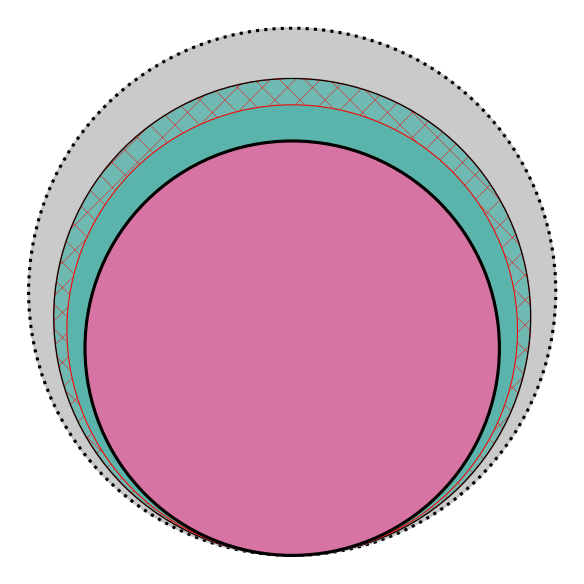

In [102]:
import matplotlib.pyplot as plt
import math

"""
# Example area values for each circle, replace these with actual values
Total_tree_cover_loss = 10
Forestloss_and_deforestation = 9
Agriculture_and_forestry_deforestation = 9
Agriculture_and_forestry_deforestation_prodcution = 9
"""
print('Total_tree_cover_loss', Total_tree_cover_loss, 
      '\nForestloss_and_deforestation:', Forestloss_and_deforestation, '(',round(Forestloss_and_deforestation*100/Total_tree_cover_loss, 1),')', 
      '\nForest_fire:',  Forest_fire, '(',round(Forest_fire*100/Total_tree_cover_loss, 1),')',
      '\nAgriculture_and_forestry_deforestation:', Agriculture_and_forestry_deforestation,'(', round(Agriculture_and_forestry_deforestation*100/Total_tree_cover_loss, 1),')',
      '\nAgriculture_and_forestry_deforestation_production:', Agriculture_and_forestry_deforestation_production, '(', round(Agriculture_and_forestry_deforestation_production*100/Total_tree_cover_loss, 1),')',)
# Create a figure and a single subplot
fig, ax = plt.subplots(dpi = 150)

# Calculate the radius from the area and draw each circle
# Adjusting the y-coordinate so the circles touch at the bottom
y_offset = math.sqrt(Total_tree_cover_loss / math.pi)
radius = math.sqrt(Total_tree_cover_loss / math.pi)
circle1 = plt.Circle((0, -y_offset + radius), radius, color='#bdbdbd', fill=True, alpha = 0.8)
ax.add_artist(circle1)
circle1 = plt.Circle((0, -y_offset + radius), radius, color='black', fill=False, lw = 1.5, ls = 'dotted')
ax.add_artist(circle1)

radius = math.sqrt(Forestloss_and_deforestation / math.pi)
circle2 = plt.Circle((0, -y_offset + radius), radius, color='#5ab4ac', fill=True, alpha = 0.8)
ax.add_artist(circle2)
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.2 
circle2 = plt.Circle((0, -y_offset + radius), radius, color='red', fill=False, lw = 0.5, hatch = 'xx')
ax.add_artist(circle2)
circle2 = plt.Circle((0, -y_offset + radius), radius, color='black', fill=False, lw = 0.5)
ax.add_artist(circle2)

radius = math.sqrt((Forestloss_and_deforestation - Forest_fire)/ math.pi)
circle2_1 = plt.Circle((0, -y_offset + radius), radius, color='#5ab4ac', fill=True, lw = 0.5)
ax.add_artist(circle2_1)
circle2_1 = plt.Circle((0, -y_offset + radius), radius, color='red', fill=False, lw = 0.5)
ax.add_artist(circle2_1)


radius = math.sqrt(Agriculture_and_forestry_deforestation / math.pi)
circle3 = plt.Circle((0, -y_offset + radius), radius, color='#d8b365', fill=True, alpha = 0.8)
ax.add_artist(circle3)
circle3 = plt.Circle((0, -y_offset + radius), radius, color='black', fill=False, lw = 0.5)
ax.add_artist(circle3)

radius = math.sqrt(Agriculture_and_forestry_deforestation_production / math.pi)
circle4 = plt.Circle((0, -y_offset + radius), radius, color='#df65b0', fill=True, alpha = 0.8)
ax.add_artist(circle4)
circle4 = plt.Circle((0, -y_offset + radius), radius, color='black', fill=False, lw = 1.5, ls = '-')
ax.add_artist(circle4)

# Set limits to include all circles
ax.set_xlim(-y_offset-100, y_offset+100)
ax.set_ylim(-y_offset-100, y_offset+100)

# Set aspect of the plot to be equal, so the circles aren't distorted
ax.set_aspect('equal', adjustable='box')
ax.axis('off')

# Show the plot
plt.show()
